In [56]:
# Import required packages
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('shot_logs.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumns available:")
for col in df.columns:
    print(f"- {col}")

# Check for the three players of interest
target_players = ['lebron james', 'stephen curry', 'james harden']
player_shots = df['player_name'].value_counts()
print("\nShot attempts for our players of interest:")
for player in target_players:
    if player in player_shots:
        print(f"{player}: {player_shots[player]} shots")
        
# Display sample of the data structure
print("\nFirst few rows of the dataset:")
display(df.head())

# Check for any missing values
missing_values = df.isnull().sum()
if missing_values.any():
    print("\nMissing values in the dataset:")
    print(missing_values[missing_values > 0])

Dataset Shape: (128069, 21)

Columns available:
- GAME_ID
- MATCHUP
- LOCATION
- W
- FINAL_MARGIN
- SHOT_NUMBER
- PERIOD
- GAME_CLOCK
- SHOT_CLOCK
- DRIBBLES
- TOUCH_TIME
- SHOT_DIST
- PTS_TYPE
- SHOT_RESULT
- CLOSEST_DEFENDER
- CLOSEST_DEFENDER_PLAYER_ID
- CLOSE_DEF_DIST
- FGM
- PTS
- player_name
- player_id

Shot attempts for our players of interest:
lebron james: 978 shots
stephen curry: 968 shots
james harden: 1054 shots

First few rows of the dataset:


,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148



Missing values in the dataset:
SHOT_CLOCK    5567
dtype: int64


In [ ]:
import pandas as pd
import numpy as np

def enhance_shot_logs(df):
    """
    Enhance the shot logs dataset with FG%, game stage, shot zone, and timing features
    """
    df = df.copy()
    print("Processing shot data...")

    # Sort chronologically
    df = df.sort_values(['player_name', 'PERIOD', 'GAME_CLOCK'], ascending=[True, True, False])

    # Group by player and game
    df['cum_fg_made'] = df.groupby(['player_name', 'GAME_ID'])['FGM'].cumsum().shift(1).fillna(0)
    df['cum_fg_attempts'] = df.groupby(['player_name', 'GAME_ID']).cumcount()

    # Calculate FG% during the current game up to that shot
    df['player_fg_pct'] = np.where(
        df['cum_fg_attempts'] > 0,
        df['cum_fg_made'] / df['cum_fg_attempts'],
        0
    )

    # Convert GAME_CLOCK to seconds
    def clock_to_sec(clock_str):
        try:
            mins, secs = map(float, clock_str.split(':'))
            return mins * 60 + secs
        except:
            return np.nan

    df['GAME_CLOCK_SEC'] = df['GAME_CLOCK'].apply(clock_to_sec)
# Handle NaN in SHOT_CLOCK
    if df['SHOT_CLOCK'].isna().any():
        print("Found NaN in SHOT_CLOCK, imputing with 14 seconds...")
        df['SHOT_CLOCK'] = pd.to_numeric(df['SHOT_CLOCK'], errors='coerce')  # convert all to float
        df['SHOT_CLOCK'] = df['SHOT_CLOCK'].fillna(14.0)  # fill NaN with 14 seconds

    # General game stage: early, mid, late based on PERIOD
    def get_game_stage(period):
        if period in [1, 2]:
            return 'early'
        elif period == 3:
            return 'mid'
        else:
            return 'late'
    df['game_stage'] = df['PERIOD'].apply(get_game_stage)

    # More detailed stage based on PERIOD + GAME_CLOCK_SEC
    conditions = [
        (df['PERIOD'].isin([1, 2])) & (df['GAME_CLOCK_SEC'] >= 540),
        (df['PERIOD'].isin([1, 2])) & (df['GAME_CLOCK_SEC'] < 540),
        (df['PERIOD'] == 3) & (df['GAME_CLOCK_SEC'] >= 540),
        (df['PERIOD'] == 3) & (df['GAME_CLOCK_SEC'] < 540),
        (df['PERIOD'] >= 4) & (df['GAME_CLOCK_SEC'] >= 180),
        (df['PERIOD'] >= 4) & (df['GAME_CLOCK_SEC'] < 180)
    ]
    choices = ['very_early', 'early', 'mid_start', 'mid_end', 'late', 'clutch']
    df['detailed_game_stage'] = np.select(conditions, choices, default='unknown')

    # Shot zone bucket
    df['shot_zone_distance'] = pd.cut(
        df['SHOT_DIST'],
        bins=[-np.inf, 4, 14, 22, np.inf],
        labels=['restricted_area', 'mid_range', 'long_range', 'deep_three']
    )

    print("Data enhancement complete.")
    return df

# Load the data
df = pd.read_csv('shot_logs.csv')

# Filter for players of interest (using correct name format)
players_of_interest = ['lebron james', 'stephen curry', 'james harden']
df_filtered = df[df['player_name'].isin(players_of_interest)]

# Enhance the filtered dataset
enhanced_df = enhance_shot_logs(df_filtered)

# Display results
def display_enhanced_stats(enhanced_df):
    """Display sample statistics from the enhanced dataset"""
    for player in players_of_interest:
        print(f"\n{'='*50}")
        print(f"Stats for {player}:")
        player_data = enhanced_df[enhanced_df['player_name'] == player]
        
        print(f"\nTotal shots: {len(player_data)}")
        if len(player_data) > 0:
            print(f"Overall FG%: {player_data['FGM'].mean():.3f}")
            
            print("\nFG% by game stage:")
            stage_stats = player_data.groupby('game_stage')['FGM'].agg(['mean', 'count'])
            print(stage_stats)
            
            print("\nFG% by detailed game stage:")
            detailed_stats = player_data.groupby('detailed_game_stage')['FGM'].agg(['mean', 'count'])
            print(detailed_stats)
            
            print("\nFG% by shot zone:")
            zone_stats = player_data.groupby('shot_zone_distance')['FGM'].agg(['mean', 'count'])
            print(zone_stats)
            
            print(f"\nAverage defender distance: {player_data['CLOSE_DEF_DIST'].mean():.2f} feet")
            print(f"Average dribbles per shot: {player_data['DRIBBLES'].mean():.2f}")
            print(f"Average FG% at time of shot: {player_data['player_fg_pct'].mean():.3f}")
        else:
            print("No shots found for this player")


# Display the statistics
display_enhanced_stats(enhanced_df)

# Show sample of enhanced data
print("\nSample of enhanced data for verification:")
sample_cols = ['player_name', 'PERIOD', 'FGM', 'player_fg_pct', 
               'game_stage', 'detailed_game_stage', 'shot_zone_distance']
print(enhanced_df[sample_cols].head(10))

# Print total number of shots for verification
print("\nTotal shots by player:")
print(enhanced_df['player_name'].value_counts())


Processing shot data...
Found NaN in SHOT_CLOCK, imputing with 14 seconds...
Data enhancement complete.

Stats for lebron james:

Total shots: 978
Overall FG%: 0.489

FG% by game stage:
                mean  count
game_stage                 
early       0.484791    526
late        0.485437    206
mid         0.500000    246

FG% by detailed game stage:
                         mean  count
detailed_game_stage                 
clutch               0.372549     51
early                0.466667    405
late                 0.522581    155
mid_end              0.516129    186
mid_start            0.450000     60
very_early           0.545455    121

FG% by shot zone:
                        mean  count
shot_zone_distance                 
restricted_area     0.745856    181
mid_range           0.510903    321
long_range          0.433155    187
deep_three          0.339100    289

Average defender distance: 4.19 feet
Average dribbles per shot: 4.67
Average FG% at time of shot: 0.493

Stats fo

Analysis started by cnguyen at 2025-06-04 09:00:01 UTC
Generating alternatives for 5 sample shots...


5it [00:00, 894.80it/s]


Alternative Generation Statistics:
Total alternatives generated: 15
Rejected alternatives: 13

Average distance to original shots: 0.319

Zone distribution of alternatives:
long_range: 33.3% (5 shots)
deep_three: 46.7% (7 shots)
mid_range: 13.3% (2 shots)
restricted_area: 6.7% (1 shots)

Group sizes:
group_id
0    4
1    4
2    4
3    4
4    4
dtype: int64

Sample of generated alternatives:
    SHOT_DIST  CLOSE_DEF_DIST  SHOT_CLOCK  GAME_CLOCK  PERIOD  DRIBBLES  \
0        18.7             4.9        12.0       598.0       1         7   
4        11.3             4.2         3.9       584.0       1         2   
8        24.5             3.5        21.0       584.0       1         0   
12       16.0             4.9        12.1       572.0       1         4   
16       24.8             3.4         8.6       568.0       1         0   

     shot_zone  game_stage  player_fg_pct  is_original  IS_CHOSEN  group_id  
0   long_range  very_early       0.000000         True          1         0 

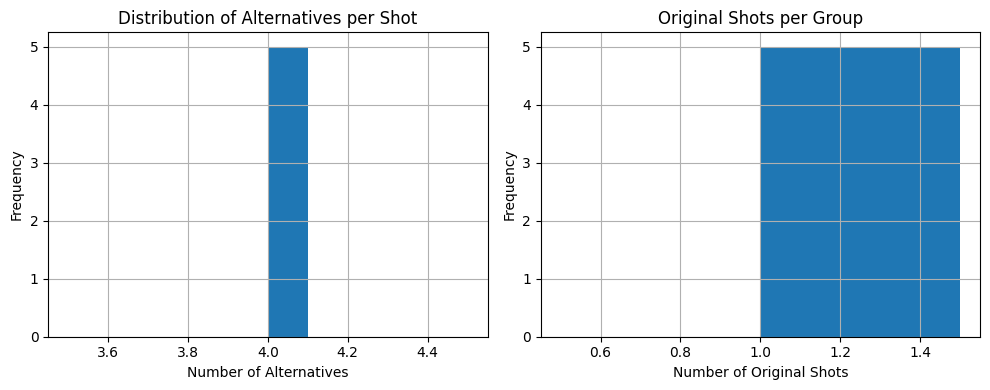

Analysis completed at 2025-06-04 09:00:02 UTC


In [65]:
import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
from datetime import datetime
import os
warnings.filterwarnings('ignore')

print(f"Analysis started by {os.getenv('USER')} at {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')} UTC")

@dataclass
class ShotAlternative:
    """Class to store shot features and metadata"""
    shot_distance: float
    defender_distance: float
    shot_clock: float
    game_clock: float
    period: int
    dribbles: int
    shot_zone: str
    game_stage: str
    player_fg_pct: float
    is_original: bool = False
    
    def to_dict(self) -> Dict:
        """Convert shot features to dictionary"""
        return {
            'SHOT_DIST': self.shot_distance,
            'CLOSE_DEF_DIST': self.defender_distance,
            'SHOT_CLOCK': self.shot_clock,
            'GAME_CLOCK': self.game_clock,
            'PERIOD': self.period,
            'DRIBBLES': self.dribbles,
            'shot_zone': self.shot_zone,
            'game_stage': self.game_stage,
            'player_fg_pct': self.player_fg_pct,
            'is_original': self.is_original,
            'IS_CHOSEN': 1 if self.is_original else 0
        }
    
    def distance_to(self, other: 'ShotAlternative') -> float:
        """Compute normalized distance to another shot"""
        return np.sqrt(
            ((self.shot_distance - other.shot_distance) / 35.0) ** 2 +
            ((self.defender_distance - other.defender_distance) / 10.0) ** 2 +
            ((self.shot_clock - other.shot_clock) / 24.0) ** 2 +
            ((self.player_fg_pct - other.player_fg_pct) / 1.0) ** 2
        )

class ShotAlternativeGenerator:
    def __init__(self, shot_data: pd.DataFrame):
        """
        Initialize the shot alternative generator with historical shot data
        
        Args:
            shot_data: DataFrame containing the enhanced shot logs
        """
        self.shot_data = shot_data
        self.zone_stats = self._calculate_zone_stats()
        self.defender_stats = self._calculate_defender_stats()
        self.generation_stats = {
            'total_alternatives': 0,
            'zone_changes': {},
            'avg_distance_to_original': [],
            'rejected_alternatives': 0
        }
    
    def _calculate_zone_stats(self) -> Dict:
        """Calculate shooting statistics by zone"""
        stats = {}
        for zone in self.shot_data['shot_zone_distance'].unique():
            zone_data = self.shot_data[self.shot_data['shot_zone_distance'] == zone]
            stats[zone] = {
                'mean_dist': zone_data['SHOT_DIST'].mean(),
                'std_dist': zone_data['SHOT_DIST'].std(),
                'freq': len(zone_data) / len(self.shot_data)
            }
        return stats
    
    def _calculate_defender_stats(self) -> Dict:
        """Calculate defender distance statistics by shot zone"""
        stats = {}
        for zone in self.shot_data['shot_zone_distance'].unique():
            zone_data = self.shot_data[self.shot_data['shot_zone_distance'] == zone]
            stats[zone] = {
                'mean_def_dist': zone_data['CLOSE_DEF_DIST'].mean(),
                'std_def_dist': zone_data['CLOSE_DEF_DIST'].std()
            }
        return stats
    
    def _generate_alternative_distance(self, 
                                    original_zone: str,
                                    allow_zone_change: bool = True) -> Tuple[float, str]:
        """Generate alternative shot distance and zone"""
        if allow_zone_change and np.random.random() < 0.3:  # 30% chance to change zone
            new_zone = np.random.choice(
                list(self.zone_stats.keys()),
                p=[stats['freq'] for stats in self.zone_stats.values()]
            )
        else:
            new_zone = original_zone
            
        zone_mean = self.zone_stats[new_zone]['mean_dist']
        zone_std = self.zone_stats[new_zone]['std_dist']
        
        new_distance = np.clip(
            np.random.normal(zone_mean, zone_std),
            0,  # Minimum shot distance
            35  # Maximum reasonable shot distance
        )
        
        return new_distance, new_zone
    
    def _generate_alternative_defender_distance(self, 
                                             shot_zone: str,
                                             original_def_dist: float) -> float:
        """Generate alternative defender distance"""
        zone_stats = self.defender_stats[shot_zone]
        
        if np.random.random() < 0.7:  # 70% chance to base it on original
            base = original_def_dist
            std = zone_stats['std_def_dist'] * 0.5
        else:
            base = zone_stats['mean_def_dist']
            std = zone_stats['std_def_dist']
            
        return np.clip(
            np.random.normal(base, std),
            0,  # Minimum defender distance
            10  # Maximum reasonable defender distance
        )
    
    def _adjust_shot_clock(self, 
                          original_clock: float,
                          game_stage: str) -> float:
        """Generate alternative shot clock value"""
        if game_stage == 'clutch':
            variation = np.random.normal(0, 1)  # Less variation in clutch
        else:
            variation = np.random.normal(0, 2)  # More variation normally
            
        return np.clip(
            original_clock + variation,
            0,  # Minimum shot clock
            24  # Maximum shot clock
        )
    
    def generate_alternatives(self,
                            original_shot: pd.Series,
                            n_alternatives: int = 3,
                            visualize: bool = False,
                            min_difference_threshold: float = 0.2
                            ) -> List[ShotAlternative]:
        """Generate alternative shots based on an original shot"""
        alternatives = []
        
        # Create original shot alternative
        original = ShotAlternative(
            shot_distance=original_shot['SHOT_DIST'],
            defender_distance=original_shot['CLOSE_DEF_DIST'],
            shot_clock=float(original_shot['SHOT_CLOCK']),
            game_clock=float(original_shot['GAME_CLOCK'].split(':')[0]) * 60 + 
                      float(original_shot['GAME_CLOCK'].split(':')[1]),
            period=original_shot['PERIOD'],
            dribbles=original_shot['DRIBBLES'],
            shot_zone=original_shot['shot_zone_distance'],
            game_stage=original_shot['detailed_game_stage'],
            player_fg_pct=original_shot['player_fg_pct'],
            is_original=True
        )
        alternatives.append(original)
        
        max_attempts = n_alternatives * 3
        attempts = 0
        
        while len(alternatives) < n_alternatives + 1 and attempts < max_attempts:
            attempts += 1
            
            new_dist, new_zone = self._generate_alternative_distance(
                original_shot['shot_zone_distance']
            )
            
            new_def_dist = self._generate_alternative_defender_distance(
                new_zone,
                original_shot['CLOSE_DEF_DIST']
            )
            
            new_shot_clock = self._adjust_shot_clock(
                float(original_shot['SHOT_CLOCK']),
                original_shot['detailed_game_stage']
            )
            new_shot_clock = min(new_shot_clock, original.game_clock)

            # Generate alternative player_fg_pct with small variation
            new_fg_pct = np.clip(
                original_shot['player_fg_pct'] + np.random.normal(0, 0.02),
                0,  # Minimum FG%
                1   # Maximum FG%
            )
            
            alternative = ShotAlternative(
                shot_distance=new_dist,
                defender_distance=new_def_dist,
                shot_clock=new_shot_clock,
                game_clock=original.game_clock,
                period=original.period,
                dribbles=max(0, int(original_shot['DRIBBLES'] + np.random.normal(0, 1))),
                shot_zone=new_zone,
                game_stage=original.game_stage,
                player_fg_pct=new_fg_pct,
                is_original=False
            )
            
            is_different = True
            for existing_alt in alternatives:
                if alternative.distance_to(existing_alt) < min_difference_threshold:
                    is_different = False
                    self.generation_stats['rejected_alternatives'] += 1
                    break
            
            if is_different:
                alternatives.append(alternative)
                self.generation_stats['total_alternatives'] += 1
                self.generation_stats['avg_distance_to_original'].append(
                    alternative.distance_to(original)
                )
                self.generation_stats['zone_changes'][new_zone] = \
                    self.generation_stats['zone_changes'].get(new_zone, 0) + 1
        
        if visualize:
            self._visualize_alternatives(alternatives)
        
        return alternatives
    
    def generate_batch_alternatives(self,
                                 shots_df: pd.DataFrame,
                                 n_alternatives: int = 3,
                                 progress_bar: bool = True) -> pd.DataFrame:
        """Generate alternatives for multiple shots"""
        all_shots = []
        group_sizes = []
        iterator = tqdm(shots_df.iterrows()) if progress_bar else shots_df.iterrows()
        
        for idx, shot in iterator:
            alternatives = self.generate_alternatives(shot, n_alternatives)
            all_shots.extend([alt.to_dict() for alt in alternatives])
            group_sizes.append(len(alternatives))
        
        result_df = pd.DataFrame(all_shots)
        
        group_ids = []
        for idx, size in enumerate(group_sizes):
            group_ids.extend([idx] * size)
        
        result_df['group_id'] = group_ids
        
        return result_df
    
    def _visualize_alternatives(self, alternatives: List[ShotAlternative]):
        """Visualize original shot and alternatives"""
        plt.figure(figsize=(15, 5))
        
        # Plot 1: Shot Distance vs Defender Distance
        plt.subplot(1, 3, 1)
        for alt in alternatives:
            color = 'red' if alt.is_original else 'blue'
            marker = '*' if alt.is_original else 'o'
            size = 200 if alt.is_original else 100
            plt.scatter(alt.shot_distance, alt.defender_distance, 
                       c=color, marker=marker, s=size, alpha=0.6)
        
        plt.xlabel('Shot Distance (feet)')
        plt.ylabel('Defender Distance (feet)')
        plt.title('Shot vs Defender Distance')
        plt.grid(True, alpha=0.3)
        
        # Plot 2: Shot Distance vs Shot Clock
        plt.subplot(1, 3, 2)
        for alt in alternatives:
            color = 'red' if alt.is_original else 'blue'
            marker = '*' if alt.is_original else 'o'
            size = 200 if alt.is_original else 100
            plt.scatter(alt.shot_distance, alt.shot_clock,
                       c=color, marker=marker, s=size, alpha=0.6)
        
        plt.xlabel('Shot Distance (feet)')
        plt.ylabel('Shot Clock (seconds)')
        plt.title('Shot Distance vs Shot Clock')
        plt.grid(True, alpha=0.3)
        
        # Plot 3: Shot Distance vs FG%
        plt.subplot(1, 3, 3)
        for alt in alternatives:
            color = 'red' if alt.is_original else 'blue'
            marker = '*' if alt.is_original else 'o'
            size = 200 if alt.is_original else 100
            plt.scatter(alt.shot_distance, alt.player_fg_pct,
                       c=color, marker=marker, s=size, alpha=0.6)
        
        plt.xlabel('Shot Distance (feet)')
        plt.ylabel('Player FG%')
        plt.title('Shot Distance vs FG%')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def print_generation_stats(self):
        """Print statistics about the alternative generation process"""
        print("\nAlternative Generation Statistics:")
        print(f"Total alternatives generated: {self.generation_stats['total_alternatives']}")
        print(f"Rejected alternatives: {self.generation_stats['rejected_alternatives']}")
        
        if self.generation_stats['avg_distance_to_original']:
            avg_distance = np.mean(self.generation_stats['avg_distance_to_original'])
            print(f"\nAverage distance to original shots: {avg_distance:.3f}")
        
        print("\nZone distribution of alternatives:")
        total_zones = sum(self.generation_stats['zone_changes'].values())
        if total_zones > 0:
            for zone, count in self.generation_stats['zone_changes'].items():
                percentage = (count / total_zones) * 100
                print(f"{zone}: {percentage:.1f}% ({count} shots)")

# Example usage
def run_alternative_generation_example(enhanced_df: pd.DataFrame):
    """Run example of alternative generation"""
    # Initialize generator
    generator = ShotAlternativeGenerator(enhanced_df)
    
    # Generate alternatives for a batch of shots
    sample_shots = enhanced_df.head(5)
    print("Generating alternatives for 5 sample shots...")
    batch_results = generator.generate_batch_alternatives(
        sample_shots,
        n_alternatives=3,
        progress_bar=True
    )
    
    # Print statistics
    generator.print_generation_stats()
    
    # Display summary of results
    print("\nGroup sizes:")
    print(batch_results.groupby('group_id').size())
    
    # Display sample of results
    print("\nSample of generated alternatives:")
    print(batch_results.groupby('group_id').head(1))
    
    # Visualize distribution of alternatives
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    batch_results.groupby('group_id').size().hist(bins=10)
    plt.title('Distribution of Alternatives per Shot')
    plt.xlabel('Number of Alternatives')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    batch_results.groupby('group_id')['is_original'].sum().hist(bins=2)
    plt.title('Original Shots per Group')
    plt.xlabel('Number of Original Shots')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    return batch_results

# Run the example if you have enhanced_df ready
if 'enhanced_df' in globals():
    batch_results = run_alternative_generation_example(enhanced_df)
else:
    print("Please run your data preparation code first to create enhanced_df")

print(f"Analysis completed at {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')} UTC")

Initial shape of enhanced dataset: (3000, 28)

Generating alternatives for lebron james
Available shots: 978
Generating 3 alternatives for 800 shots...


0it [00:00, ?it/s]

800it [00:00, 1442.86it/s]



Alternative Generation Statistics:
Total alternatives generated: 2108
Rejected alternatives: 3336

Average distance to original shots: 0.421

Zone distribution of alternatives:
restricted_area: 18.9% (399 shots)
deep_three: 36.1% (760 shots)
mid_range: 28.5% (601 shots)
long_range: 16.5% (348 shots)

Generating alternatives for stephen curry
Available shots: 968
Generating 3 alternatives for 800 shots...


800it [00:00, 1660.05it/s]



Alternative Generation Statistics:
Total alternatives generated: 2149
Rejected alternatives: 3280

Average distance to original shots: 0.414

Zone distribution of alternatives:
deep_three: 41.8% (899 shots)
long_range: 15.4% (331 shots)
mid_range: 25.1% (540 shots)
restricted_area: 17.6% (379 shots)

Generating alternatives for james harden
Available shots: 1054
Generating 3 alternatives for 800 shots...


800it [00:00, 863.55it/s] 



Alternative Generation Statistics:
Total alternatives generated: 2108
Rejected alternatives: 3324

Average distance to original shots: 0.409

Zone distribution of alternatives:
mid_range: 25.6% (539 shots)
restricted_area: 20.8% (438 shots)
deep_three: 38.2% (805 shots)
long_range: 15.5% (326 shots)

Summary of generated alternatives:

Statistics for lebron james:
Original shots: 800
Alternative shots: 2108

Original Shot Averages:
Distance: 14.12 feet
Defender Distance: 4.24 feet
Shot Clock: 11.76 seconds

Alternative Shot Averages:
Distance: 14.75 feet
Defender Distance: 4.19 feet
Shot Clock: 11.48 seconds

Statistics for stephen curry:
Original shots: 800
Alternative shots: 2149

Original Shot Averages:
Distance: 17.44 feet
Defender Distance: 4.55 feet
Shot Clock: 14.95 seconds

Alternative Shot Averages:
Distance: 15.61 feet
Defender Distance: 4.45 feet
Shot Clock: 14.72 seconds

Statistics for james harden:
Original shots: 800
Alternative shots: 2108

Original Shot Averages:
Dist

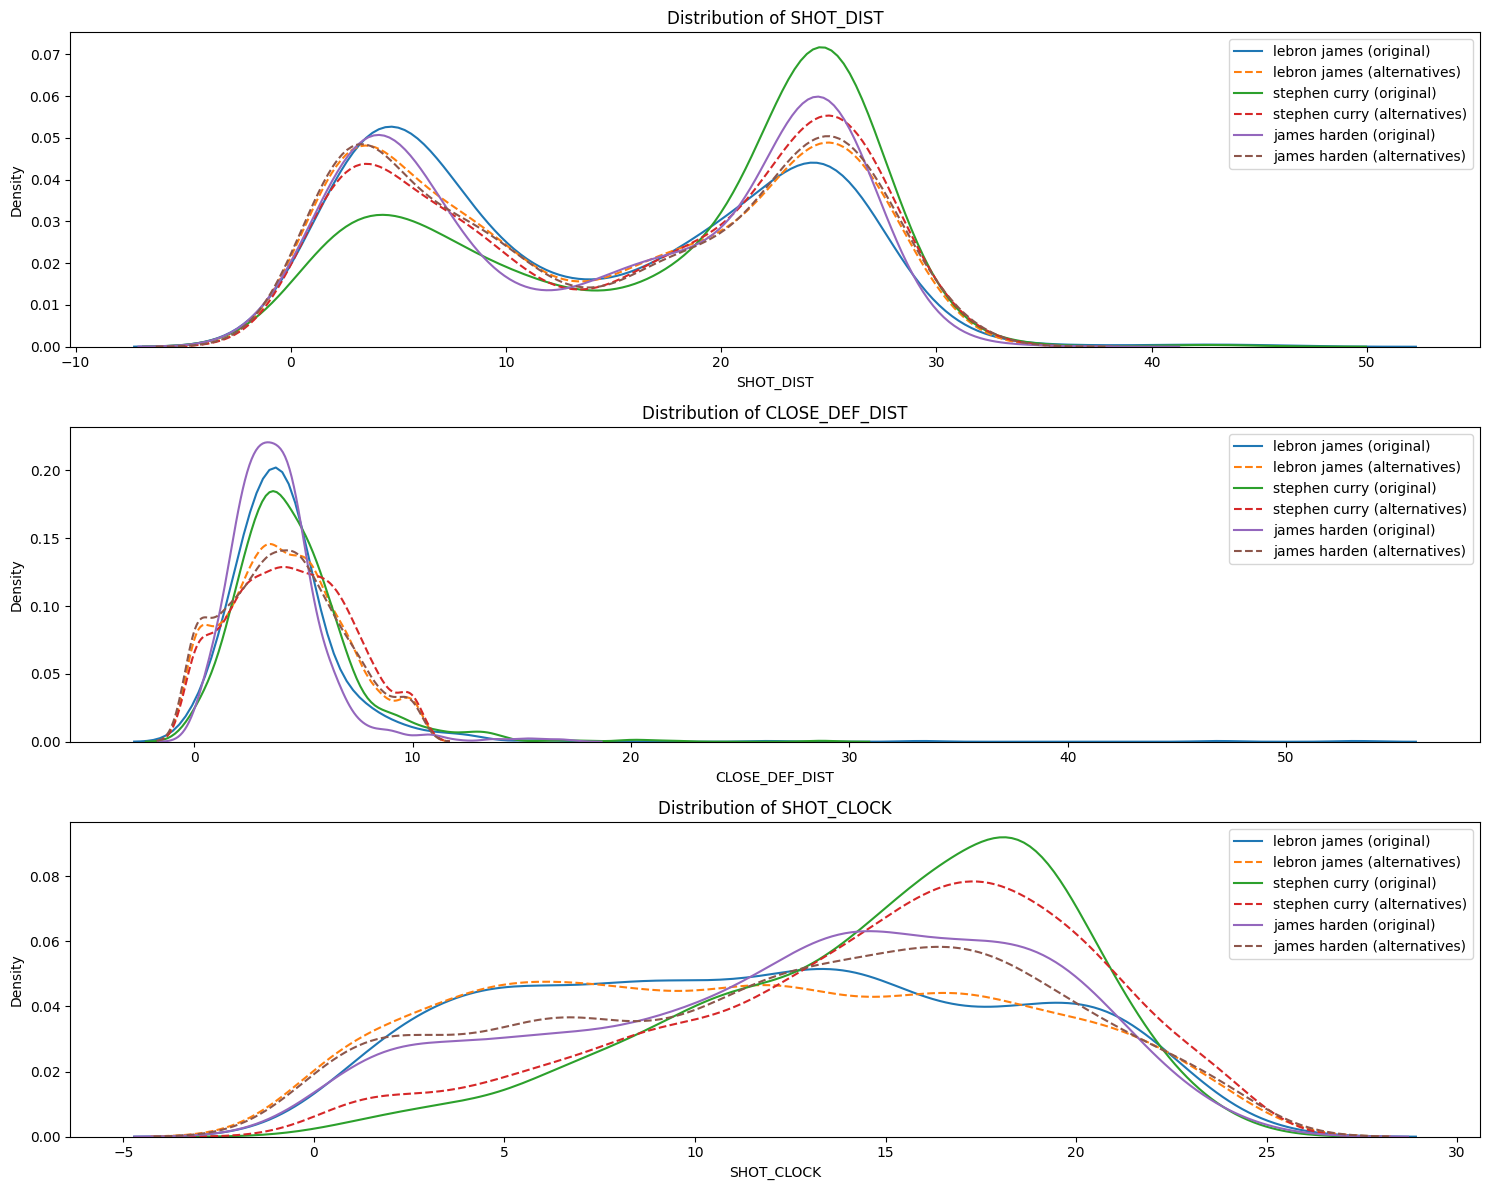


Results saved to 'shot_alternatives.csv'

Sample of generated alternatives:


,SHOT_DIST,CLOSE_DEF_DIST,SHOT_CLOCK,GAME_CLOCK,PERIOD,DRIBBLES,shot_zone,game_stage,player_fg_pct,is_original,IS_CHOSEN,group_id,player_name
0,5.7,0.0,14.0,705.0,1,0,mid_range,very_early,0.507538,True,1,0,lebron james
4,3.5,1.9,18.2,551.0,3,3,restricted_area,mid_start,0.493554,True,1,1,lebron james
8,5.8,2.5,22.5,110.0,1,1,mid_range,early,0.522989,True,1,2,lebron james
10,6.3,2.3,16.6,694.0,4,8,mid_range,late,0.487069,True,1,3,lebron james
14,18.9,5.5,14.4,448.0,1,11,long_range,early,0.454545,True,1,4,lebron james


In [66]:
# First, make sure your enhanced_df is ready
print("Initial shape of enhanced dataset:", enhanced_df.shape)

def generate_player_alternatives(enhanced_df, player_name, n_shots=800, n_alternatives=3):
    """
    Generate shot alternatives for a specific player
    
    Args:
        enhanced_df: The enhanced dataframe from your previous code
        player_name: Name of the player to analyze
        n_shots: Number of shots to analyze
        n_alternatives: Number of alternatives to generate per shot
    """
    # Filter for player
    player_data = enhanced_df[enhanced_df['player_name'].str.lower() == player_name.lower()]
    
    print(f"\nGenerating alternatives for {player_name}")
    print(f"Available shots: {len(player_data)}")
    
    # Take specified number of shots
    player_data = player_data.sample(n=n_shots, random_state=42)
    
    # Initialize generator with full dataset for better statistics
    generator = ShotAlternativeGenerator(enhanced_df)
    
    # Generate alternatives
    print(f"Generating {n_alternatives} alternatives for {n_shots} shots...")
    batch_results = generator.generate_batch_alternatives(
        player_data,
        n_alternatives=n_alternatives,
        progress_bar=True
    )
    
    # Print statistics
    generator.print_generation_stats()
    
    # Add player name to results
    batch_results['player_name'] = player_name
    
    return batch_results

# Generate alternatives for each player
all_results = []
for player in players_of_interest:  # Using your existing players_of_interest list
    player_results = generate_player_alternatives(
        enhanced_df,
        player_name=player,
        n_shots=800,  # You can adjust this number
        n_alternatives=3
    )
    all_results.append(player_results)

# Combine all results
combined_results = pd.concat(all_results, ignore_index=True)

# Display summary statistics
print("\nSummary of generated alternatives:")
for player in players_of_interest:
    player_data = combined_results[combined_results['player_name'] == player]
    orig_shots = player_data[player_data['is_original']]
    alt_shots = player_data[~player_data['is_original']]
    
    print(f"\n{'='*50}")
    print(f"Statistics for {player}:")
    print(f"Original shots: {len(orig_shots)}")
    print(f"Alternative shots: {len(alt_shots)}")
    
    print("\nOriginal Shot Averages:")
    print(f"Distance: {orig_shots['SHOT_DIST'].mean():.2f} feet")
    print(f"Defender Distance: {orig_shots['CLOSE_DEF_DIST'].mean():.2f} feet")
    print(f"Shot Clock: {orig_shots['SHOT_CLOCK'].mean():.2f} seconds")
    
    print("\nAlternative Shot Averages:")
    print(f"Distance: {alt_shots['SHOT_DIST'].mean():.2f} feet")
    print(f"Defender Distance: {alt_shots['CLOSE_DEF_DIST'].mean():.2f} feet")
    print(f"Shot Clock: {alt_shots['SHOT_CLOCK'].mean():.2f} seconds")

# Visualize distributions
plt.figure(figsize=(15, 12))

for idx, feature in enumerate(['SHOT_DIST', 'CLOSE_DEF_DIST', 'SHOT_CLOCK']):
    plt.subplot(3, 1, idx+1)
    for player in players_of_interest:
        player_data = combined_results[combined_results['player_name'] == player]
        
        # Original shots
        sns.kdeplot(data=player_data[player_data['is_original']][feature], 
                   label=f'{player} (original)',
                   linestyle='-')
        
        # Alternative shots
        sns.kdeplot(data=player_data[~player_data['is_original']][feature],
                   label=f'{player} (alternatives)',
                   linestyle='--')
    
    plt.title(f'Distribution of {feature}')
    plt.legend()

plt.tight_layout()
plt.show()

# Save the results (optional)
combined_results.to_csv('shot_alternatives.csv', index=False)
print("\nResults saved to 'shot_alternatives.csv'")

# Display sample of the results
print("\nSample of generated alternatives:")
display(combined_results.groupby(['player_name', 'group_id']).head(1).head())

Analysis started by cnguyen at 2025-06-04 09:20:48 UTC
Starting player analysis...

Analyzing lebron james's decision making:



Epoch 1/10
Train Loss: 0.7197, Train Acc: 0.3225
Val Loss: 0.7149, Val Acc: 0.3832



Epoch 2/10
Train Loss: 0.6798, Train Acc: 0.5326
Val Loss: 0.6694, Val Acc: 0.6014



Epoch 3/10
Train Loss: 0.6276, Train Acc: 0.6359
Val Loss: 0.6243, Val Acc: 0.6838



Epoch 4/10
Train Loss: 0.5827, Train Acc: 0.6997
Val Loss: 0.5860, Val Acc: 0.7440



Epoch 5/10
Train Loss: 0.5498, Train Acc: 0.7227
Val Loss: 0.5528, Val Acc: 0.7612



Epoch 6/10
Train Loss: 0.5407, Train Acc: 0.7339
Val Loss: 0.5488, Val Acc: 0.7526



Epoch 7/10
Train Loss: 0.5425, Train Acc: 0.7313
Val Loss: 0.5354, Val Acc: 0.7595



Epoch 8/10
Train Loss: 0.5302, Train Acc: 0.7344
Val Loss: 0.5256, Val Acc: 0.7595



Epoch 9/10
Train Loss: 0.5313, Train Acc: 0.7365
Val Loss: 0.5200, Val Acc: 0.7612



Epoch 10/10
Train Loss: 0.5141, Train Acc: 0.7465
Val Loss: 0.5171, Val Acc: 0.7680


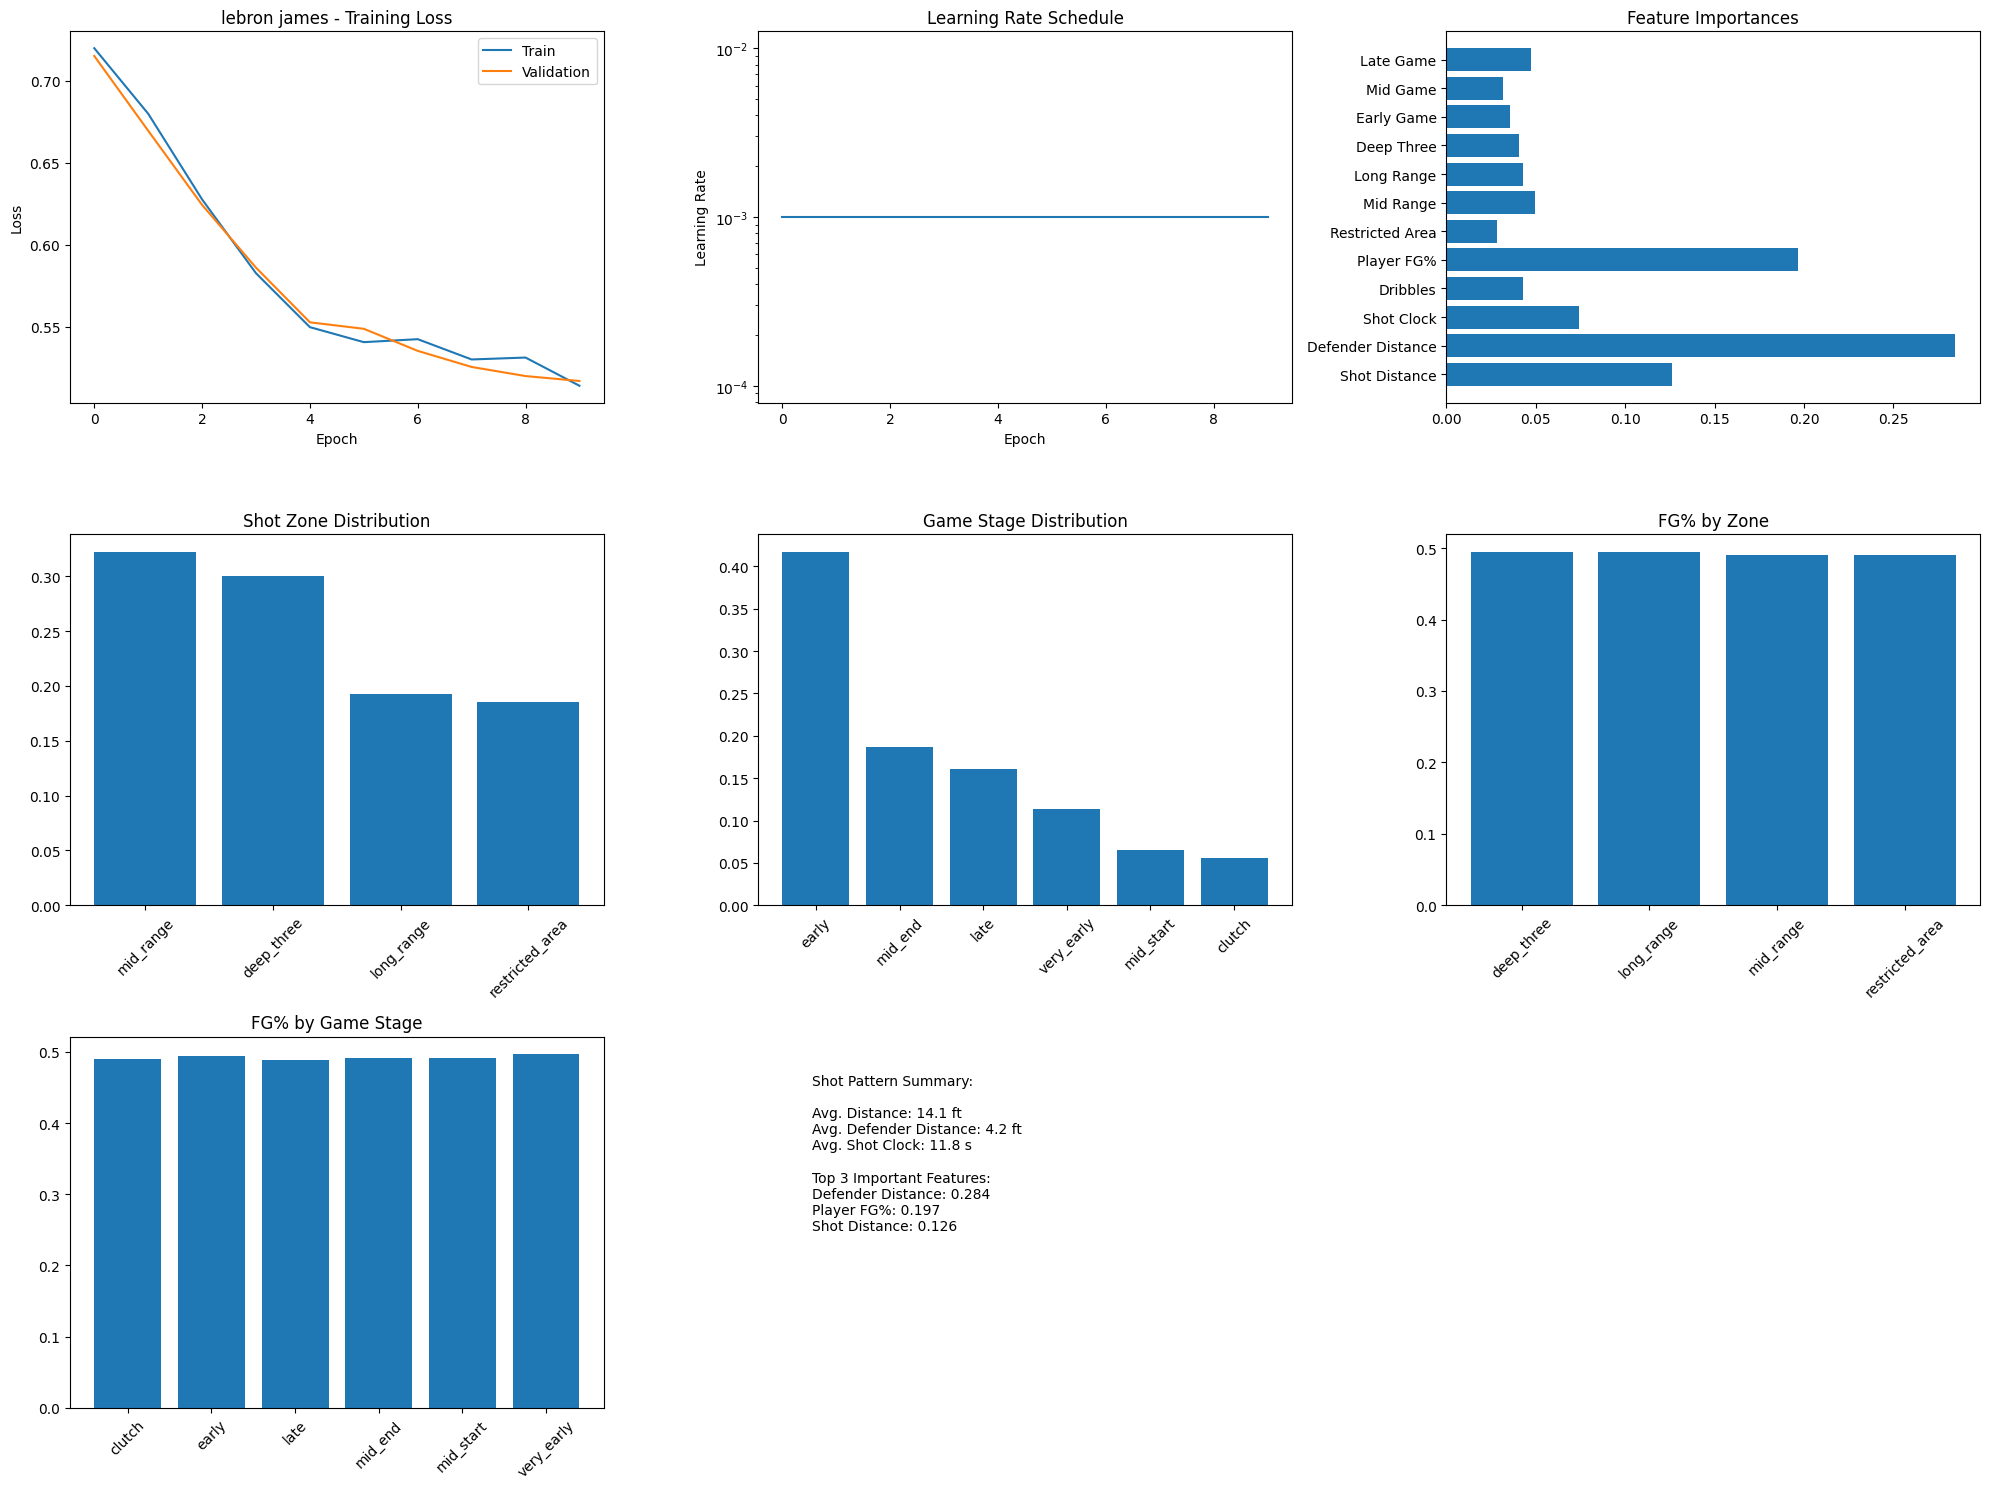


Analyzing stephen curry's decision making:



Epoch 1/10
Train Loss: 0.7099, Train Acc: 0.3711
Val Loss: 0.6972, Val Acc: 0.4678



Epoch 2/10
Train Loss: 0.6779, Train Acc: 0.5467
Val Loss: 0.6580, Val Acc: 0.6322



Epoch 3/10
Train Loss: 0.6394, Train Acc: 0.6515
Val Loss: 0.6039, Val Acc: 0.7068



Epoch 4/10
Train Loss: 0.5948, Train Acc: 0.7059
Val Loss: 0.5725, Val Acc: 0.7169



Epoch 5/10
Train Loss: 0.5680, Train Acc: 0.7286
Val Loss: 0.5507, Val Acc: 0.7203



Epoch 6/10
Train Loss: 0.5506, Train Acc: 0.7324
Val Loss: 0.5289, Val Acc: 0.7203



Epoch 7/10
Train Loss: 0.5466, Train Acc: 0.7269
Val Loss: 0.5304, Val Acc: 0.7203



Epoch 8/10
Train Loss: 0.5440, Train Acc: 0.7316
Val Loss: 0.5258, Val Acc: 0.7186



Epoch 9/10
Train Loss: 0.5380, Train Acc: 0.7303
Val Loss: 0.5183, Val Acc: 0.7220



Epoch 10/10
Train Loss: 0.5316, Train Acc: 0.7389
Val Loss: 0.5088, Val Acc: 0.7305


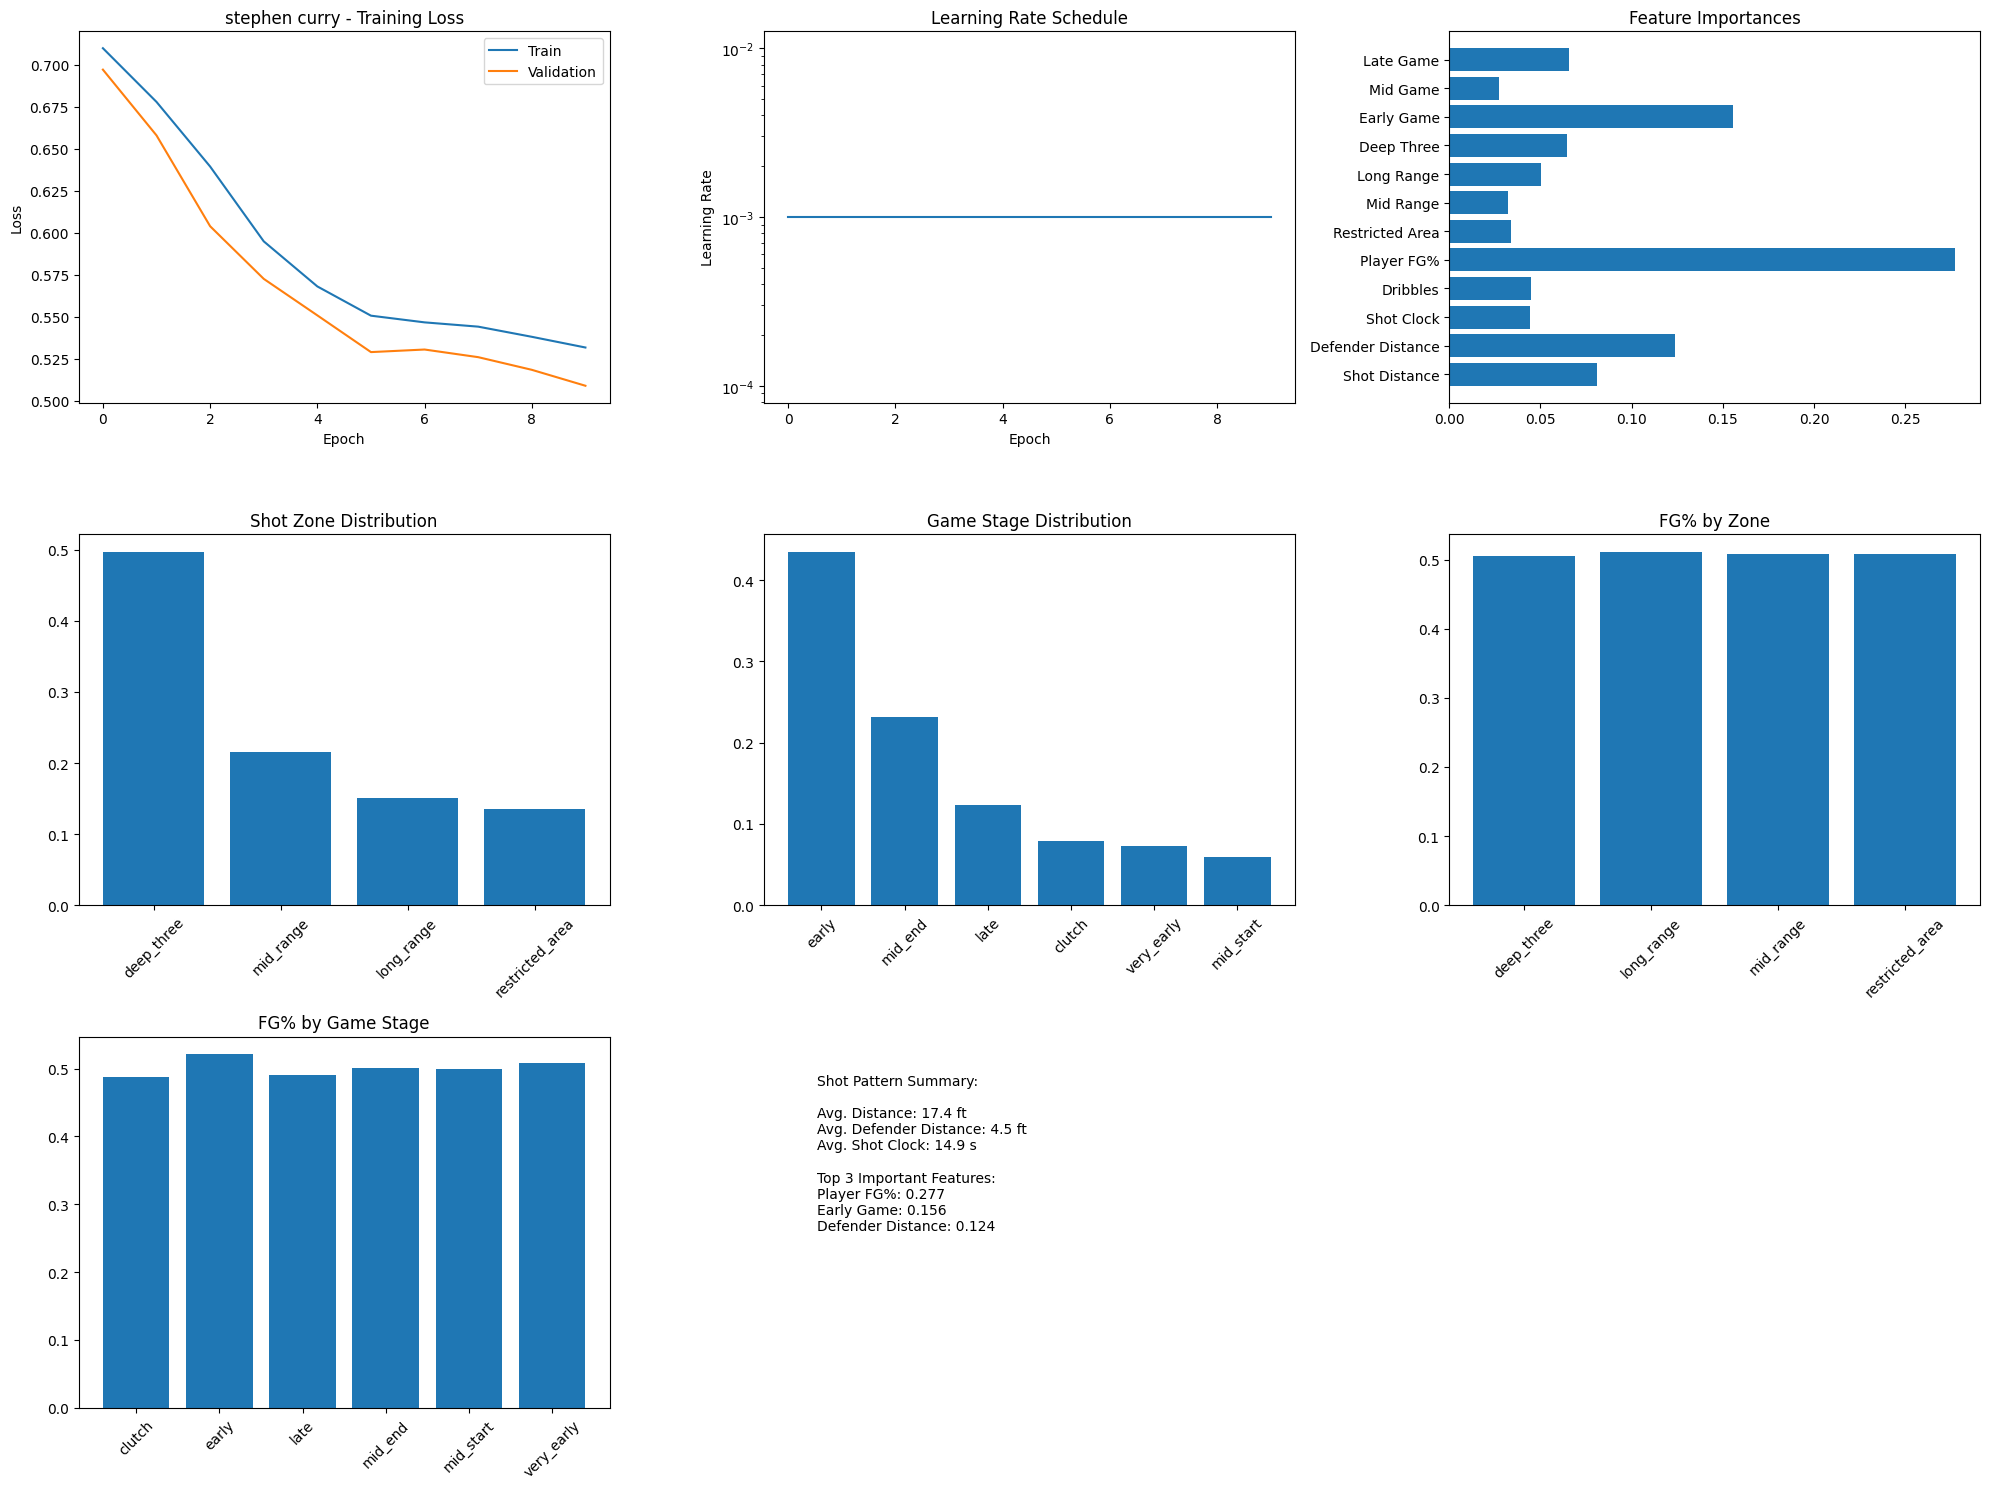


Analyzing james harden's decision making:



Epoch 1/10
Train Loss: 0.6421, Train Acc: 0.7261
Val Loss: 0.6348, Val Acc: 0.7165



Epoch 2/10
Train Loss: 0.6144, Train Acc: 0.7227
Val Loss: 0.6101, Val Acc: 0.6942



Epoch 3/10
Train Loss: 0.5789, Train Acc: 0.7313
Val Loss: 0.5744, Val Acc: 0.7199



Epoch 4/10
Train Loss: 0.5451, Train Acc: 0.7374
Val Loss: 0.5419, Val Acc: 0.7337



Epoch 5/10
Train Loss: 0.5207, Train Acc: 0.7548
Val Loss: 0.5243, Val Acc: 0.7371



Epoch 6/10
Train Loss: 0.5153, Train Acc: 0.7487
Val Loss: 0.5163, Val Acc: 0.7509



Epoch 7/10
Train Loss: 0.5108, Train Acc: 0.7565
Val Loss: 0.5110, Val Acc: 0.7474



Epoch 8/10
Train Loss: 0.5064, Train Acc: 0.7591
Val Loss: 0.5102, Val Acc: 0.7526



Epoch 9/10
Train Loss: 0.5109, Train Acc: 0.7491
Val Loss: 0.5051, Val Acc: 0.7474



Epoch 10/10
Train Loss: 0.5096, Train Acc: 0.7565
Val Loss: 0.5007, Val Acc: 0.7646


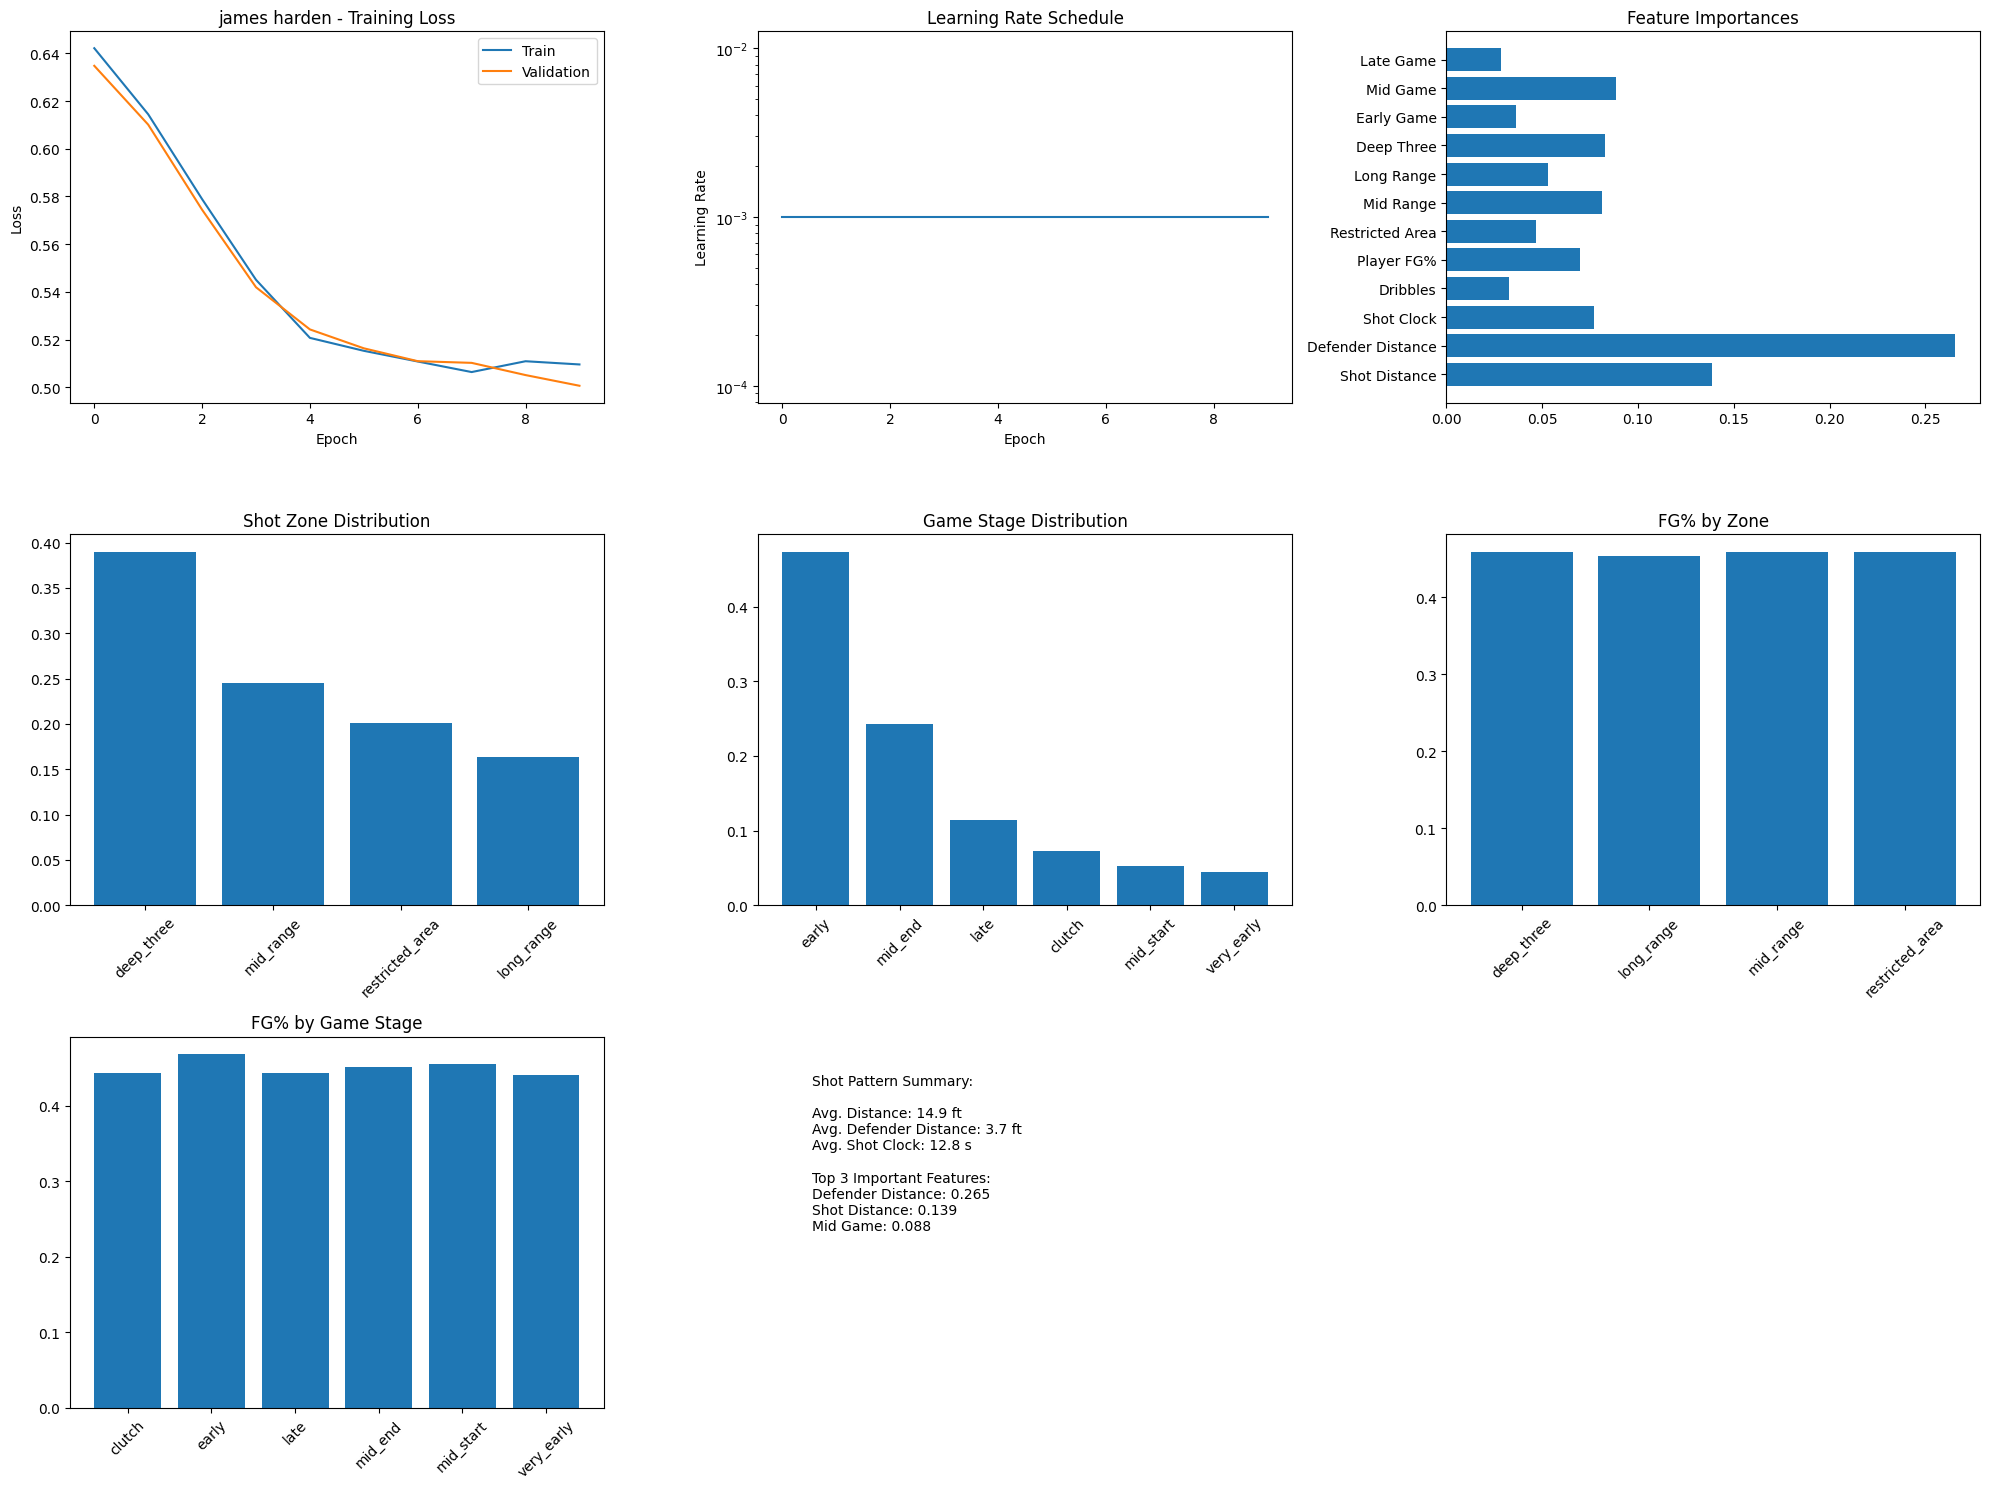


Results saved to player_analysis_results_20250604_092124.pkl

Analysis completed at 2025-06-04 09:21:24 UTC


In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
import os
from datetime import datetime
from tqdm import tqdm
import pickle

print(f"Analysis started by {os.getenv('USER')} at {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')} UTC")

class ShotCostFunction(nn.Module):
    """Neural network to represent the shot cost function with improved architecture"""
    def __init__(self, input_dim=12):  # Input dimension updated
        super(ShotCostFunction, self).__init__()
        
        hidden_dims = [64, 32, 16]
        layers = []
        prev_dim = input_dim
        
        for i, hidden_dim in enumerate(hidden_dims):
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.LeakyReLU(0.2),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(0.3 if i == 0 else 0.2)
            ])
            prev_dim = hidden_dim
        
        final_layer = nn.Linear(prev_dim, 1)
        nn.init.xavier_uniform_(final_layer.weight, gain=0.01)
        layers.append(final_layer)
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

class ShotDataset(Dataset):
    """Dataset for shot alternatives with additional features"""
    def __init__(self, data: pd.DataFrame):
        self.data = data.copy()

        # Ensure numerical values
        numerical_features = [
            'SHOT_DIST', 'CLOSE_DEF_DIST', 'SHOT_CLOCK', 'DRIBBLES',
            'player_fg_pct'
        ]
        
        for col in numerical_features:
            self.data[col] = pd.to_numeric(self.data[col], errors='coerce')
        
        # Drop rows with NaN values
        self.data = self.data.dropna(subset=numerical_features)
        
        # Normalize numerical features
        self.feature_means = {}
        self.feature_stds = {}
        
        for feature in numerical_features:
            self.feature_means[feature] = self.data[feature].mean()
            self.feature_stds[feature] = self.data[feature].std() or 1.0
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Create feature vector with all relevant features
        features = [
            # Normalized numerical features
            (row['SHOT_DIST'] - self.feature_means['SHOT_DIST']) / self.feature_stds['SHOT_DIST'],
            (row['CLOSE_DEF_DIST'] - self.feature_means['CLOSE_DEF_DIST']) / self.feature_stds['CLOSE_DEF_DIST'],
            (row['SHOT_CLOCK'] - self.feature_means['SHOT_CLOCK']) / self.feature_stds['SHOT_CLOCK'],
            (row['DRIBBLES'] - self.feature_means['DRIBBLES']) / self.feature_stds['DRIBBLES'],
            (row['player_fg_pct'] - self.feature_means['player_fg_pct']) / self.feature_stds['player_fg_pct'],
            
            # Shot zone one-hot encoding
            1.0 if row['shot_zone'] == 'restricted_area' else 0.0,
            1.0 if row['shot_zone'] == 'mid_range' else 0.0,
            1.0 if row['shot_zone'] == 'long_range' else 0.0,
            1.0 if row['shot_zone'] == 'deep_three' else 0.0,
            
            # Game stage one-hot encoding
            1.0 if row['game_stage'] == 'early' else 0.0,
            1.0 if row['game_stage'] == 'mid' else 0.0,
            1.0 if row['game_stage'] == 'late' else 0.0
        ]
        
        features = torch.tensor(features, dtype=torch.float32)
        label = torch.tensor(row['IS_CHOSEN'], dtype=torch.float32)
        group = torch.tensor(row['group_id'], dtype=torch.long)
        
        return features, label, group
class InverseOptimizer:
    def __init__(self, 
                 learning_rate: float = 0.001,
                 n_epochs: int = 200,
                 batch_size: int = 32,
                 early_stopping_patience: int = 20):
        self.cost_function = ShotCostFunction()
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.early_stopping_patience = early_stopping_patience
        
        self.optimizer = optim.AdamW(
            self.cost_function.parameters(),
            lr=learning_rate,
            weight_decay=0.01
        )
        
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=5,
            verbose=True
        )
        
        self.criterion = nn.BCEWithLogitsLoss(reduction='mean')
    
    def train(self, dataset: ShotDataset) -> Dict:
        """Train the cost function with improved training loop"""
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(
            dataset, 
            [train_size, val_size],
            generator=torch.Generator().manual_seed(42)
        )
        
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=True
        )
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )
        
        history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': [],
            'learning_rates': []
        }
        
        best_val_loss = float('inf')
        best_model_state = None
        patience_counter = 0
        min_epochs = 50
        
        for epoch in range(self.n_epochs):
            # Training phase
            self.cost_function.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            train_iterator = tqdm(
                train_loader,
                desc=f'Epoch {epoch+1}/{self.n_epochs} [Train]',
                leave=False
            )
            
            for features, labels, _ in train_iterator:
                self.optimizer.zero_grad()
                outputs = self.cost_function(features)
                loss = self.criterion(outputs.squeeze(), labels)
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(self.cost_function.parameters(), max_norm=1.0)
                self.optimizer.step()
                
                train_loss += loss.item()
                pred = (torch.sigmoid(outputs) > 0.5).float()
                train_correct += (pred.squeeze() == labels).sum().item()
                train_total += labels.size(0)
                
                train_iterator.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{train_correct/train_total:.4f}'
                })
            
            # Validation phase
            self.cost_function.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                val_iterator = tqdm(
                    val_loader,
                    desc=f'Epoch {epoch+1}/{self.n_epochs} [Val]',
                    leave=False
                )
                
                for features, labels, _ in val_iterator:
                    outputs = self.cost_function(features)
                    loss = self.criterion(outputs.squeeze(), labels)
                    val_loss += loss.item()
                    pred = (torch.sigmoid(outputs) > 0.5).float()
                    val_correct += (pred.squeeze() == labels).sum().item()
                    val_total += labels.size(0)
                    
                    val_iterator.set_postfix({
                        'loss': f'{loss.item():.4f}',
                        'acc': f'{val_correct/val_total:.4f}'
                    })
            
            # Calculate metrics
            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)
            train_acc = train_correct / train_total
            val_acc = val_correct / val_total
            
            # Store metrics
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(avg_val_loss)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)
            history['learning_rates'].append(self.optimizer.param_groups[0]['lr'])
            
            print(f"\nEpoch {epoch+1}/{self.n_epochs}")
            print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
            
            self.scheduler.step(avg_val_loss)
            
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_state = self.cost_function.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
            
            if epoch >= min_epochs and patience_counter >= self.early_stopping_patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
        
        if best_model_state is not None:
            self.cost_function.load_state_dict(best_model_state)
        
        return history
    
    def get_feature_importances(self, dataset: ShotDataset) -> Dict[str, float]:
        """Calculate feature importances"""
        self.cost_function.eval()
        feature_names = [
            'Shot Distance', 'Defender Distance', 'Shot Clock', 'Dribbles',
            'Player FG%',
            'Restricted Area', 'Mid Range', 'Long Range', 'Deep Three',
            'Early Game', 'Mid Game', 'Late Game'
        ]
        
        importances = torch.zeros(len(feature_names))
        count = 0
        
        for features, _, _ in DataLoader(dataset, batch_size=32):
            features = features.clone().detach().requires_grad_(True)
            
            output = self.cost_function(features)
            
            for i in range(output.size(0)):
                if features.grad is not None:
                    features.grad.zero_()
                
                output[i].backward(retain_graph=True)
                
                if features.grad is not None:
                    importances += torch.abs(features.grad[i]).detach()
                    count += 1
        
        importances = importances / count if count > 0 else importances
        importances = importances.numpy()
        importances = importances / (importances.sum() + 1e-10)
        
        return dict(zip(feature_names, importances))
def analyze_player_decision_making(combined_results: pd.DataFrame, players: List[str]):
    """Analyze decision making patterns for each player"""
    results = {}
    
    for player in players:
        print(f"\n{'='*50}")
        print(f"Analyzing {player}'s decision making:")
        
        player_data = combined_results[combined_results['player_name'] == player].copy()
        dataset = ShotDataset(player_data)
        
        optimizer = InverseOptimizer(
            learning_rate=0.001,
            n_epochs=10,
            batch_size=32,
            early_stopping_patience=20
        )
        
        try:
            history = optimizer.train(dataset)
            importances = optimizer.get_feature_importances(dataset)
            
            # Get detailed shot patterns
            orig_shots = player_data[player_data['is_original']]
            
            shot_patterns = {
                'avg_distance': orig_shots['SHOT_DIST'].mean(),
                'avg_defender_dist': orig_shots['CLOSE_DEF_DIST'].mean(),
                'avg_shot_clock': orig_shots['SHOT_CLOCK'].mean(),
                'zone_distribution': orig_shots['shot_zone'].value_counts(normalize=True).to_dict(),
                'game_stage_distribution': orig_shots['game_stage'].value_counts(normalize=True).to_dict(),
                'fg_pct_by_zone': orig_shots.groupby('shot_zone')['player_fg_pct'].mean().to_dict(),
                'fg_pct_by_game_stage': orig_shots.groupby('game_stage')['player_fg_pct'].mean().to_dict()
            }
            
            results[player] = {
                'history': history,
                'importances': importances,
                'shot_patterns': shot_patterns
            }
            
            plot_player_analysis(player, results[player])
            
        except Exception as e:
            print(f"Error analyzing {player}: {str(e)}")
            continue
    
    return results

def plot_player_analysis(player_name: str, player_results: Dict):
    """Create comprehensive visualization of player analysis results"""
    plt.figure(figsize=(20, 15))
    
    # Training history
    plt.subplot(3, 3, 1)
    plt.plot(player_results['history']['train_loss'], label='Train')
    plt.plot(player_results['history']['val_loss'], label='Validation')
    plt.title(f'{player_name} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Learning rate
    plt.subplot(3, 3, 2)
    plt.plot(player_results['history']['learning_rates'])
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    
    # Feature importances
    plt.subplot(3, 3, 3)
    features = list(player_results['importances'].keys())
    values = list(player_results['importances'].values())
    y_pos = np.arange(len(features))
    plt.barh(y_pos, values)
    plt.yticks(y_pos, features)
    plt.title('Feature Importances')
    
    # Shot zone distribution
    plt.subplot(3, 3, 4)
    zones = list(player_results['shot_patterns']['zone_distribution'].keys())
    zone_freqs = list(player_results['shot_patterns']['zone_distribution'].values())
    plt.bar(zones, zone_freqs)
    plt.xticks(rotation=45)
    plt.title('Shot Zone Distribution')
    
    # Game stage distribution
    plt.subplot(3, 3, 5)
    stages = list(player_results['shot_patterns']['game_stage_distribution'].keys())
    stage_freqs = list(player_results['shot_patterns']['game_stage_distribution'].values())
    plt.bar(stages, stage_freqs)
    plt.xticks(rotation=45)
    plt.title('Game Stage Distribution')
    
    # FG% by zone
    plt.subplot(3, 3, 6)
    fg_zones = list(player_results['shot_patterns']['fg_pct_by_zone'].keys())
    fg_pcts = list(player_results['shot_patterns']['fg_pct_by_zone'].values())
    plt.bar(fg_zones, fg_pcts)
    plt.xticks(rotation=45)
    plt.title('FG% by Zone')
    
    # FG% by game stage
    plt.subplot(3, 3, 7)
    fg_stages = list(player_results['shot_patterns']['fg_pct_by_game_stage'].keys())
    fg_stage_pcts = list(player_results['shot_patterns']['fg_pct_by_game_stage'].values())
    plt.bar(fg_stages, fg_stage_pcts)
    plt.xticks(rotation=45)
    plt.title('FG% by Game Stage')
    
    # Summary statistics
    plt.subplot(3, 3, 8)
    plt.axis('off')
    summary_text = (
        f"Shot Pattern Summary:\n\n"
        f"Avg. Distance: {player_results['shot_patterns']['avg_distance']:.1f} ft\n"
        f"Avg. Defender Distance: {player_results['shot_patterns']['avg_defender_dist']:.1f} ft\n"
        f"Avg. Shot Clock: {player_results['shot_patterns']['avg_shot_clock']:.1f} s\n\n"
        f"Top 3 Important Features:\n"
    )
    
    sorted_features = sorted(player_results['importances'].items(), key=lambda x: x[1], reverse=True)
    for feature, importance in sorted_features[:3]:
        summary_text += f"{feature}: {importance:.3f}\n"
    
    plt.text(0.1, 0.9, summary_text, fontsize=10, va='top')
    
    plt.tight_layout()
    plt.show()

# Run the analysis
print("Starting player analysis...")
results = analyze_player_decision_making(combined_results, players_of_interest)

# Save results
timestamp = datetime.utcnow().strftime('%Y%m%d_%H%M%S')
output_file = f'player_analysis_results_{timestamp}.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(results, f)
print(f"\nResults saved to {output_file}")

print(f"\nAnalysis completed at {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')} UTC")

Analysis started by cnguyen at 2025-06-04 21:17:48 UTC
Starting player analysis...

Analyzing lebron james's decision making:



Epoch 1/10
Train Loss: 0.6491, Train Acc: 0.7201
Val Loss: 0.6375, Val Acc: 0.7440



Epoch 2/10
Train Loss: 0.6312, Train Acc: 0.7183
Val Loss: 0.6168, Val Acc: 0.7423



Epoch 3/10
Train Loss: 0.5975, Train Acc: 0.7188
Val Loss: 0.5853, Val Acc: 0.7423



Epoch 4/10
Train Loss: 0.5671, Train Acc: 0.7174
Val Loss: 0.5704, Val Acc: 0.7285



Epoch 5/10
Train Loss: 0.5510, Train Acc: 0.7244
Val Loss: 0.5470, Val Acc: 0.7526



Epoch 6/10
Train Loss: 0.5430, Train Acc: 0.7309
Val Loss: 0.5431, Val Acc: 0.7440



Epoch 7/10
Train Loss: 0.5327, Train Acc: 0.7357
Val Loss: 0.5324, Val Acc: 0.7595



Epoch 8/10
Train Loss: 0.5275, Train Acc: 0.7365
Val Loss: 0.5258, Val Acc: 0.7577



Epoch 9/10
Train Loss: 0.5228, Train Acc: 0.7474
Val Loss: 0.5264, Val Acc: 0.7629



Epoch 10/10
Train Loss: 0.5219, Train Acc: 0.7487
Val Loss: 0.5179, Val Acc: 0.7715


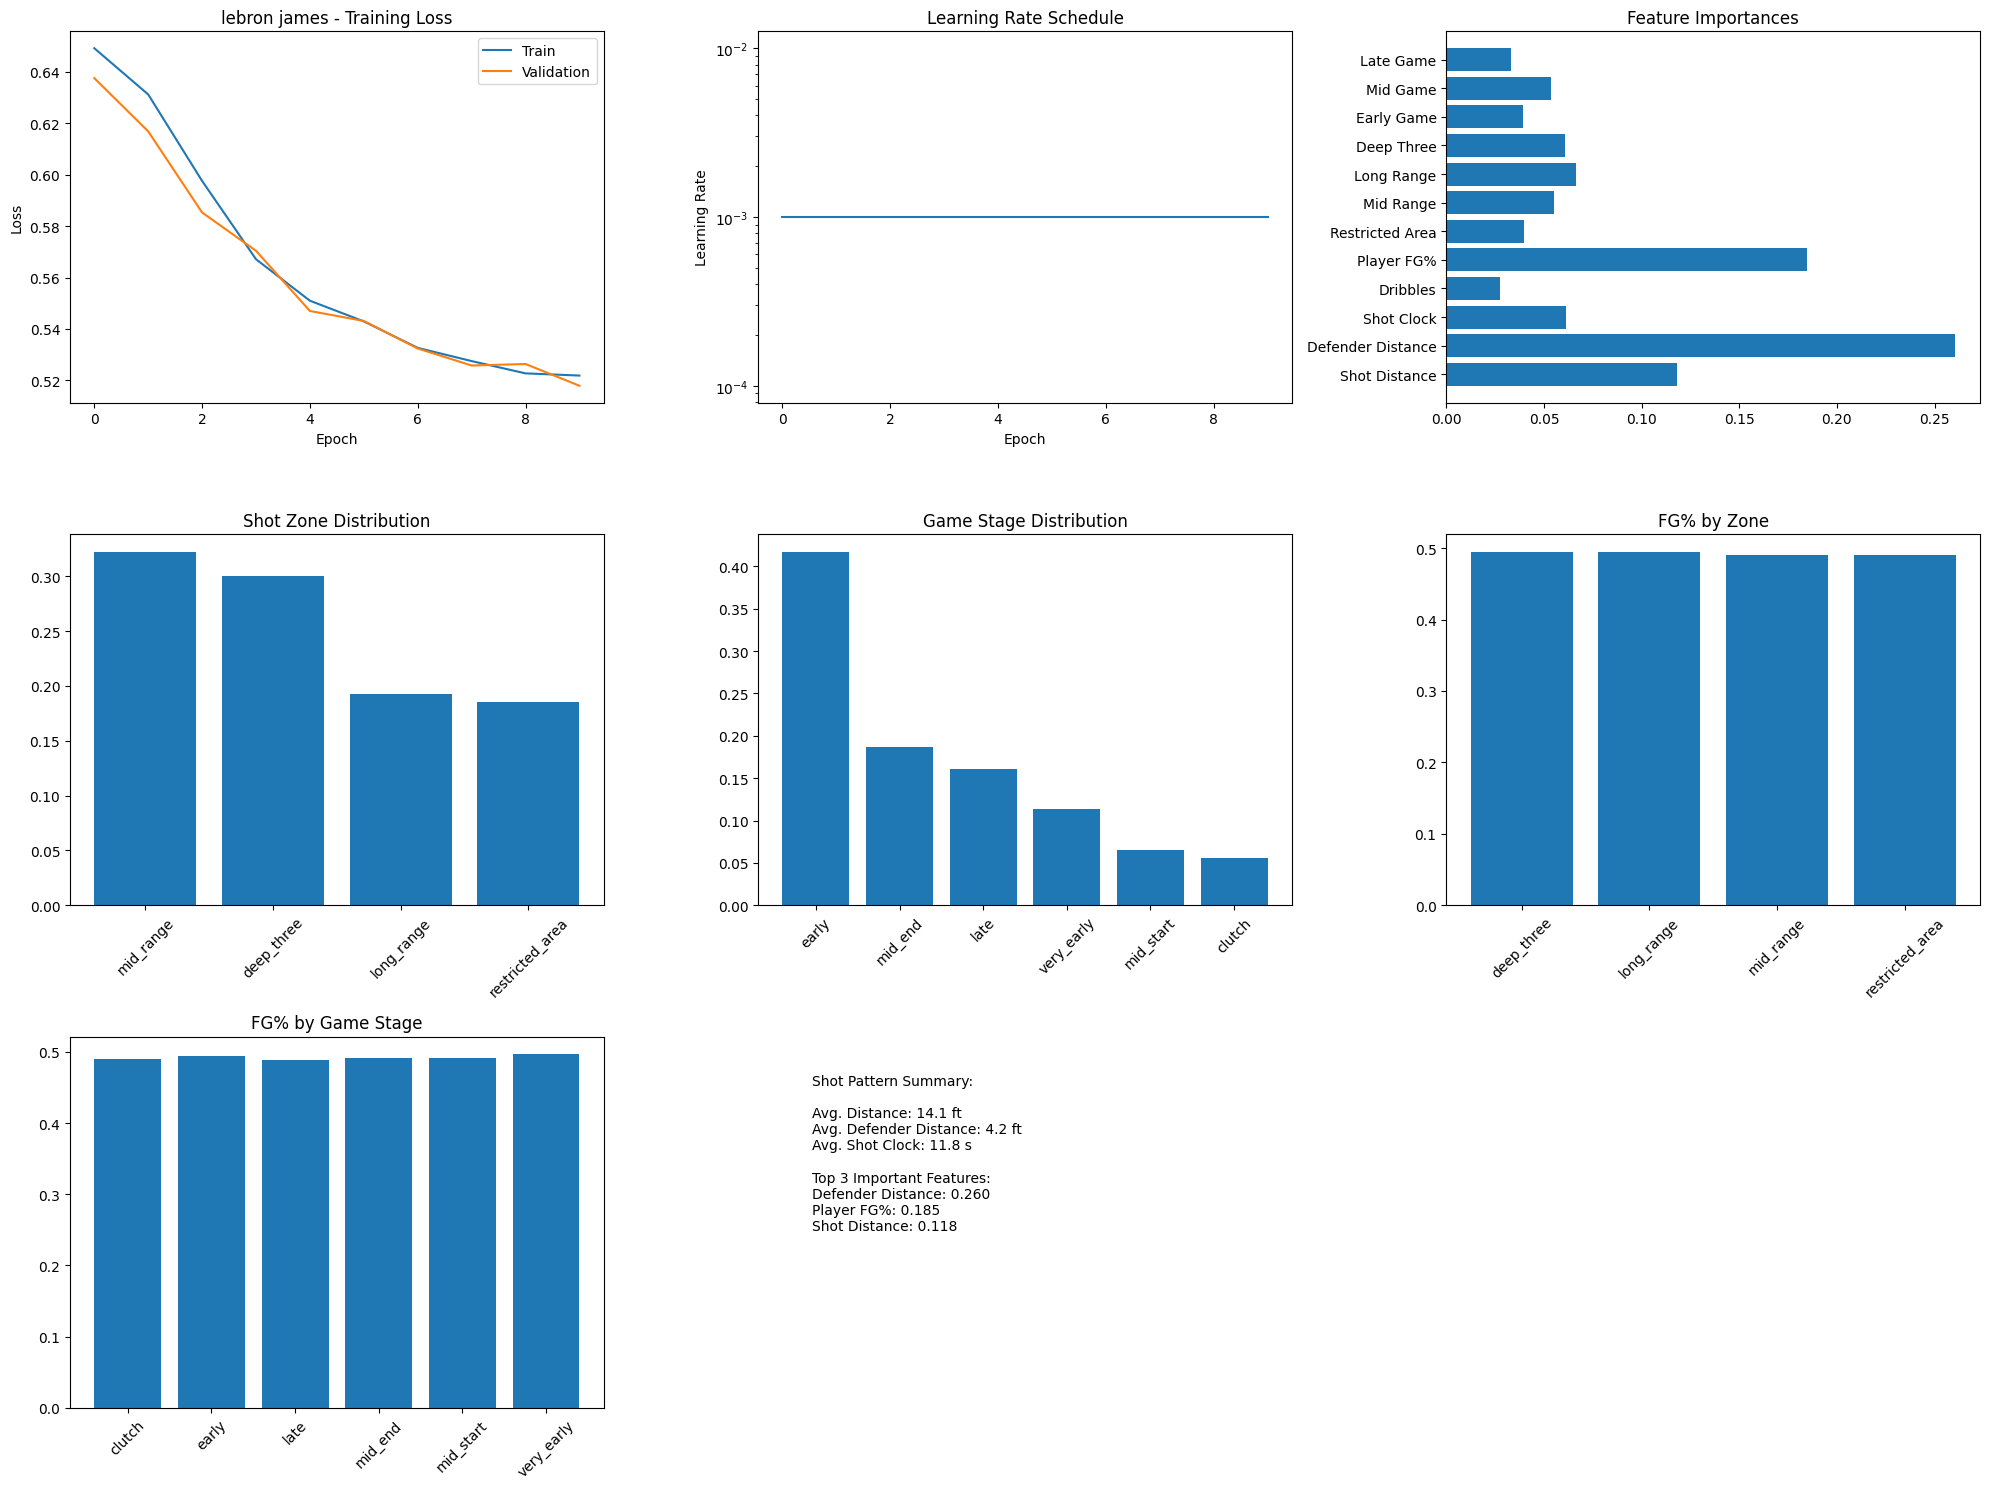


Analyzing stephen curry's decision making:



Epoch 1/10
Train Loss: 0.6634, Train Acc: 0.7303
Val Loss: 0.6585, Val Acc: 0.7203



Epoch 2/10
Train Loss: 0.6399, Train Acc: 0.7247
Val Loss: 0.6339, Val Acc: 0.7119



Epoch 3/10
Train Loss: 0.6104, Train Acc: 0.7085
Val Loss: 0.5985, Val Acc: 0.7203



Epoch 4/10
Train Loss: 0.5814, Train Acc: 0.7192
Val Loss: 0.5698, Val Acc: 0.7186



Epoch 5/10
Train Loss: 0.5653, Train Acc: 0.7170
Val Loss: 0.5510, Val Acc: 0.7203



Epoch 6/10
Train Loss: 0.5490, Train Acc: 0.7290
Val Loss: 0.5443, Val Acc: 0.7169



Epoch 7/10
Train Loss: 0.5531, Train Acc: 0.7269
Val Loss: 0.5367, Val Acc: 0.7203



Epoch 8/10
Train Loss: 0.5477, Train Acc: 0.7299
Val Loss: 0.5318, Val Acc: 0.7203



Epoch 9/10
Train Loss: 0.5368, Train Acc: 0.7350
Val Loss: 0.5194, Val Acc: 0.7237



Epoch 10/10
Train Loss: 0.5379, Train Acc: 0.7252
Val Loss: 0.5189, Val Acc: 0.7220


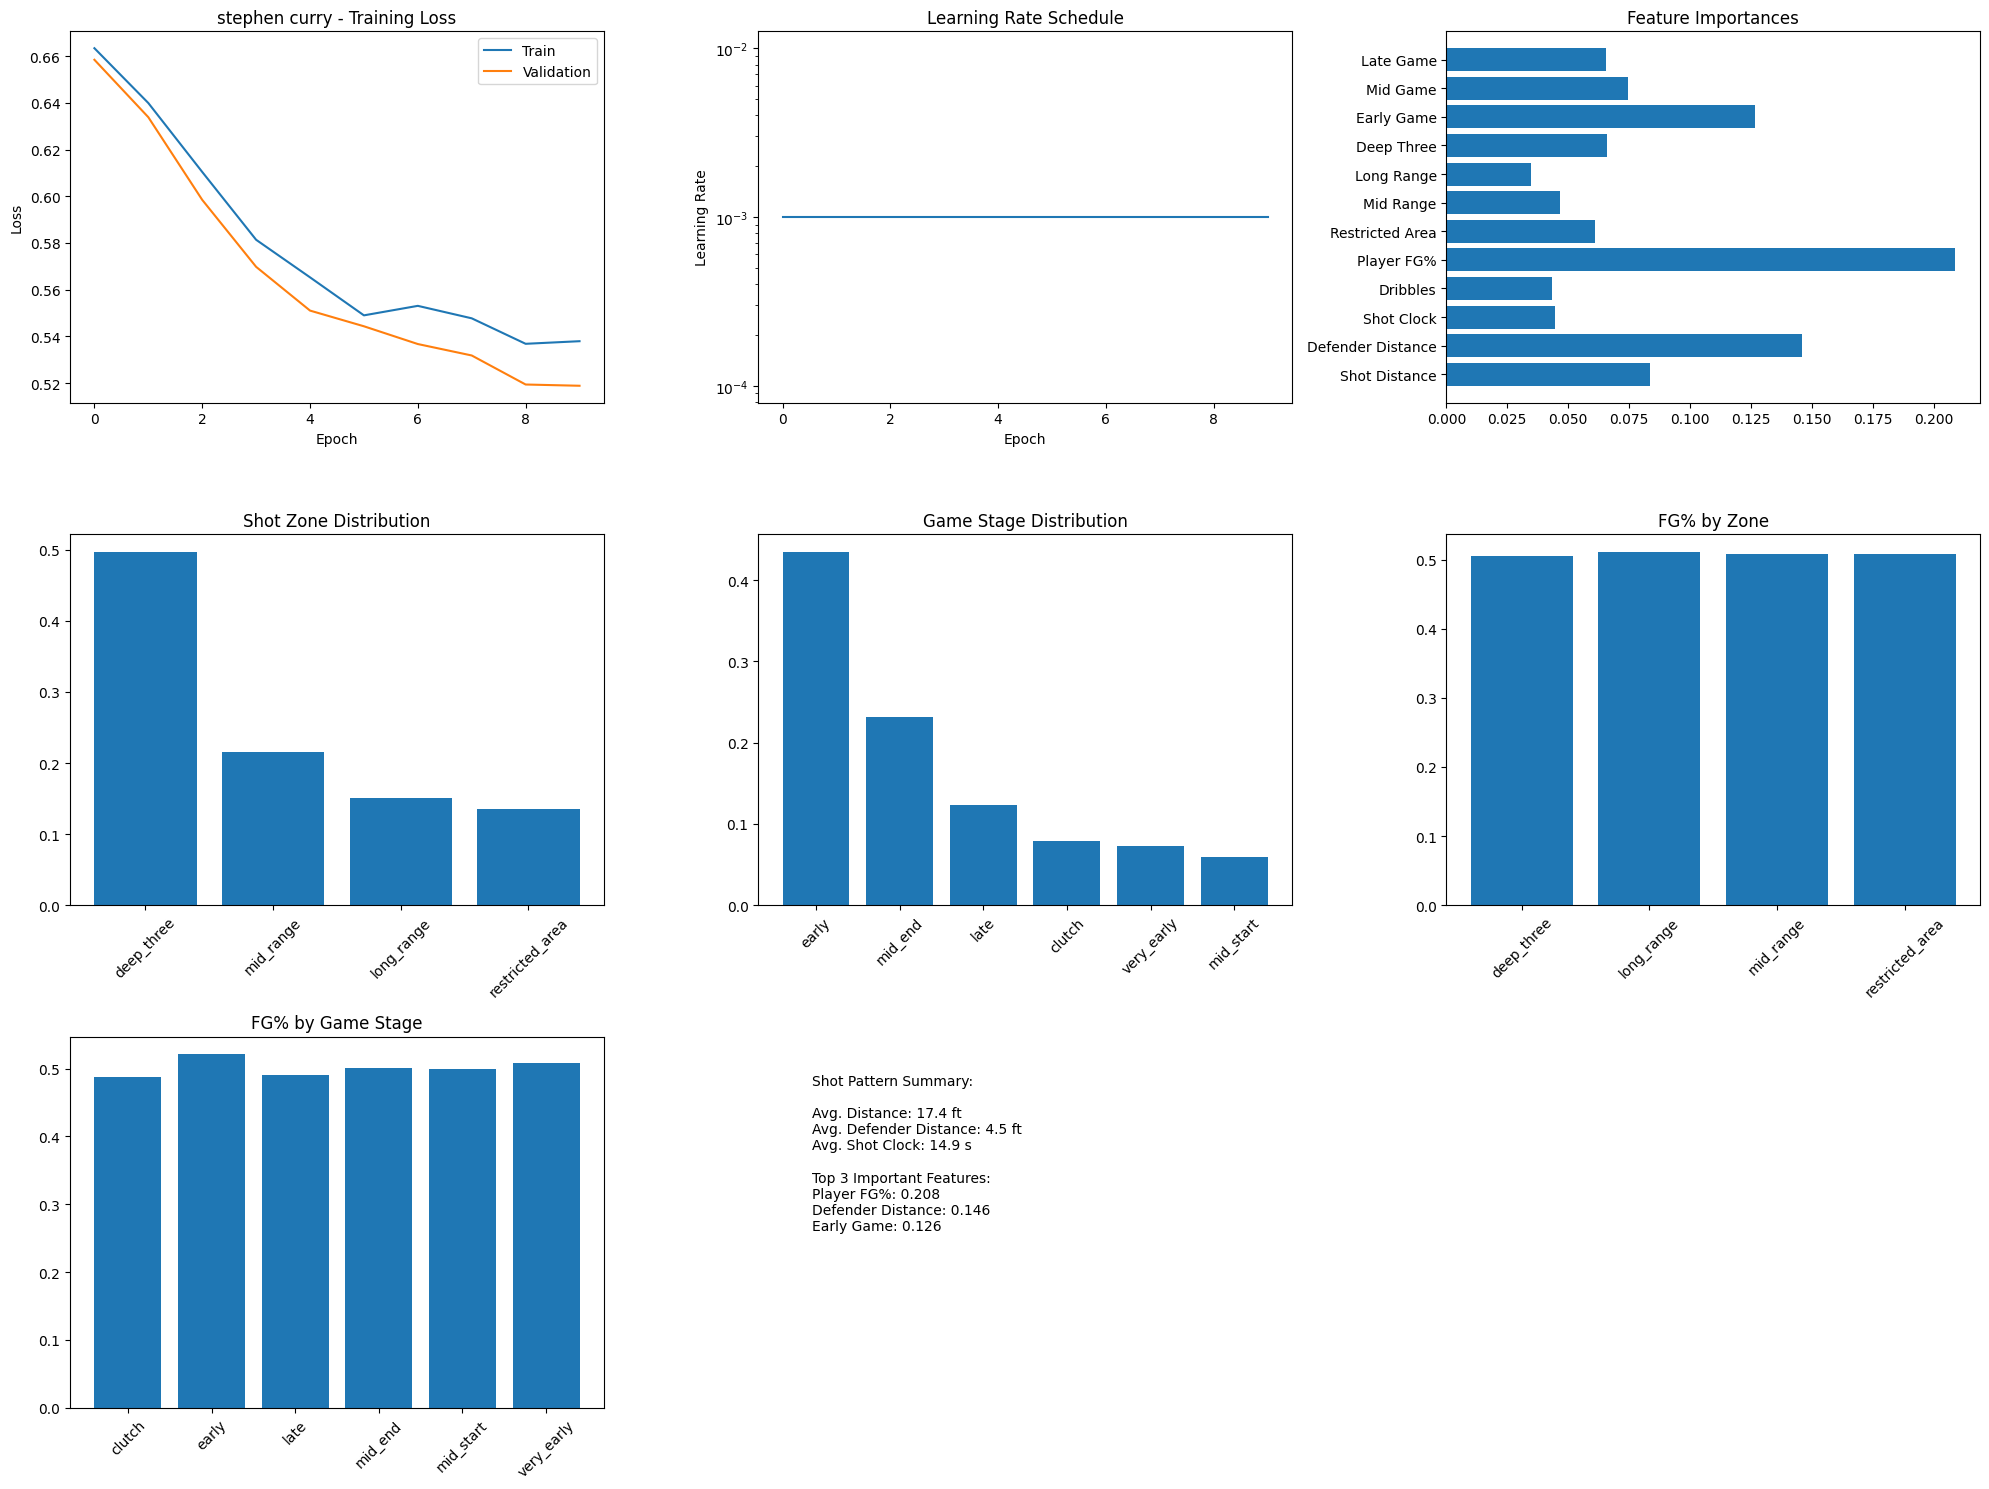


Analyzing james harden's decision making:



Epoch 1/10
Train Loss: 0.6911, Train Acc: 0.4770
Val Loss: 0.6812, Val Acc: 0.6082



Epoch 2/10
Train Loss: 0.6509, Train Acc: 0.6354
Val Loss: 0.6390, Val Acc: 0.6804



Epoch 3/10
Train Loss: 0.5992, Train Acc: 0.6984
Val Loss: 0.5952, Val Acc: 0.6907



Epoch 4/10
Train Loss: 0.5625, Train Acc: 0.7201
Val Loss: 0.5561, Val Acc: 0.7371



Epoch 5/10
Train Loss: 0.5341, Train Acc: 0.7400
Val Loss: 0.5300, Val Acc: 0.7457



Epoch 6/10
Train Loss: 0.5276, Train Acc: 0.7422
Val Loss: 0.5228, Val Acc: 0.7371



Epoch 7/10
Train Loss: 0.5123, Train Acc: 0.7483
Val Loss: 0.5107, Val Acc: 0.7491



Epoch 8/10
Train Loss: 0.5086, Train Acc: 0.7591
Val Loss: 0.5131, Val Acc: 0.7646



Epoch 9/10
Train Loss: 0.5119, Train Acc: 0.7613
Val Loss: 0.5026, Val Acc: 0.7629



Epoch 10/10
Train Loss: 0.5052, Train Acc: 0.7648
Val Loss: 0.5088, Val Acc: 0.7543


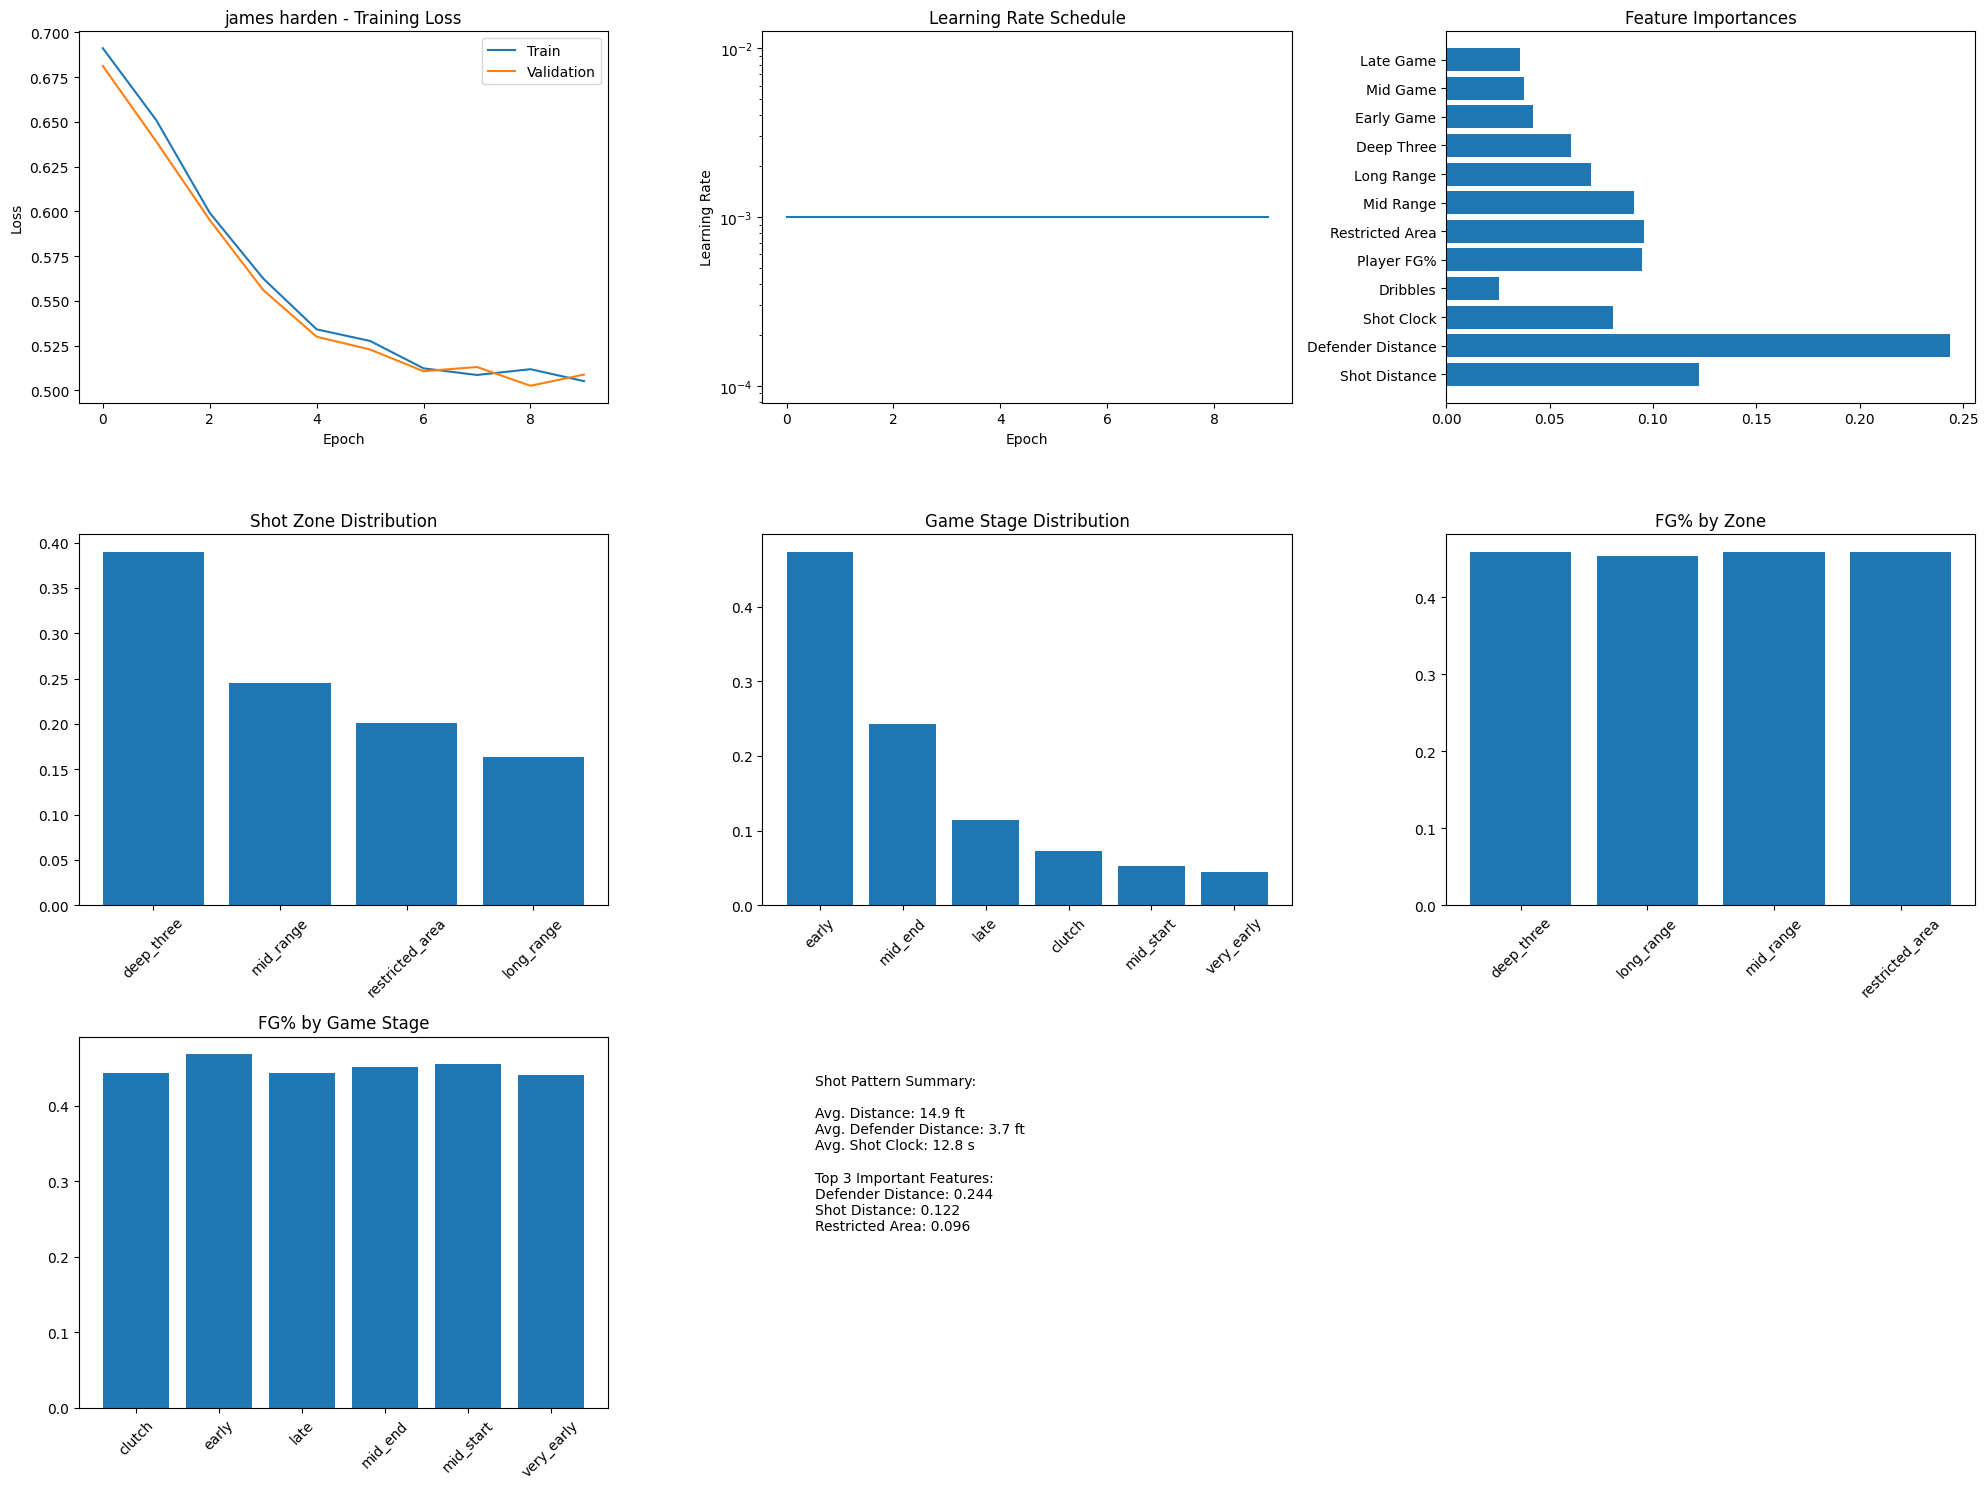


Results saved to player_analysis_results_20250604_211823.pkl

Analysis completed at 2025-06-04 21:18:23 UTC


In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
import os
from datetime import datetime
from tqdm import tqdm
import pickle

print(f"Analysis started by {os.getenv('USER')} at {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')} UTC")

class ShotCostFunction(nn.Module):
    """Neural network to represent the shot cost function with improved architecture"""
    def __init__(self, input_dim=12):  # Input dimension updated
        super(ShotCostFunction, self).__init__()
        
        hidden_dims = [64, 32, 16]
        layers = []
        prev_dim = input_dim
        
        for i, hidden_dim in enumerate(hidden_dims):
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.LeakyReLU(0.2),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(0.3 if i == 0 else 0.2)
            ])
            prev_dim = hidden_dim
        
        final_layer = nn.Linear(prev_dim, 1)
        nn.init.xavier_uniform_(final_layer.weight, gain=0.01)
        layers.append(final_layer)
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

class ShotDataset(Dataset):
    """Dataset for shot alternatives with additional features"""
    def __init__(self, data: pd.DataFrame):
        self.data = data.copy()

        # Ensure numerical values
        numerical_features = [
            'SHOT_DIST', 'CLOSE_DEF_DIST', 'SHOT_CLOCK', 'DRIBBLES',
            'player_fg_pct'
        ]
        
        for col in numerical_features:
            self.data[col] = pd.to_numeric(self.data[col], errors='coerce')
        
        # Drop rows with NaN values
        self.data = self.data.dropna(subset=numerical_features)
        
        # Normalize numerical features
        self.feature_means = {}
        self.feature_stds = {}
        
        for feature in numerical_features:
            self.feature_means[feature] = self.data[feature].mean()
            self.feature_stds[feature] = self.data[feature].std() or 1.0
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Create feature vector with all relevant features
        features = [
            # Normalized numerical features
            (row['SHOT_DIST'] - self.feature_means['SHOT_DIST']) / self.feature_stds['SHOT_DIST'],
            (row['CLOSE_DEF_DIST'] - self.feature_means['CLOSE_DEF_DIST']) / self.feature_stds['CLOSE_DEF_DIST'],
            (row['SHOT_CLOCK'] - self.feature_means['SHOT_CLOCK']) / self.feature_stds['SHOT_CLOCK'],
            (row['DRIBBLES'] - self.feature_means['DRIBBLES']) / self.feature_stds['DRIBBLES'],
            (row['player_fg_pct'] - self.feature_means['player_fg_pct']) / self.feature_stds['player_fg_pct'],
            
            # Shot zone one-hot encoding
            1.0 if row['shot_zone'] == 'restricted_area' else 0.0,
            1.0 if row['shot_zone'] == 'mid_range' else 0.0,
            1.0 if row['shot_zone'] == 'long_range' else 0.0,
            1.0 if row['shot_zone'] == 'deep_three' else 0.0,
            
            # Game stage one-hot encoding
            1.0 if row['game_stage'] == 'early' else 0.0,
            1.0 if row['game_stage'] == 'mid' else 0.0,
            1.0 if row['game_stage'] == 'late' else 0.0
        ]
        
        features = torch.tensor(features, dtype=torch.float32)
        label = torch.tensor(row['IS_CHOSEN'], dtype=torch.float32)
        group = torch.tensor(row['group_id'], dtype=torch.long)
        
        return features, label, group
class InverseOptimizer:
    def __init__(self, 
                 learning_rate: float = 0.001,
                 n_epochs: int = 200,
                 batch_size: int = 32,
                 early_stopping_patience: int = 20):
        self.cost_function = ShotCostFunction()
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.early_stopping_patience = early_stopping_patience
        
        self.optimizer = optim.AdamW(
            self.cost_function.parameters(),
            lr=learning_rate,
            weight_decay=0.01
        )
        
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=5,
            verbose=True
        )
        
        self.criterion = nn.BCEWithLogitsLoss(reduction='mean')
    
    def train(self, dataset: ShotDataset) -> Dict:
        """Train the cost function with improved training loop"""
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(
            dataset, 
            [train_size, val_size],
            generator=torch.Generator().manual_seed(42)
        )
        
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=True
        )
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )
        
        history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': [],
            'learning_rates': []
        }
        
        best_val_loss = float('inf')
        best_model_state = None
        patience_counter = 0
        min_epochs = 50
        
        for epoch in range(self.n_epochs):
            # Training phase
            self.cost_function.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            train_iterator = tqdm(
                train_loader,
                desc=f'Epoch {epoch+1}/{self.n_epochs} [Train]',
                leave=False
            )
            
            for features, labels, _ in train_iterator:
                self.optimizer.zero_grad()
                outputs = self.cost_function(features)
                loss = self.criterion(outputs.squeeze(), labels)
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(self.cost_function.parameters(), max_norm=1.0)
                self.optimizer.step()
                
                train_loss += loss.item()
                pred = (torch.sigmoid(outputs) > 0.5).float()
                train_correct += (pred.squeeze() == labels).sum().item()
                train_total += labels.size(0)
                
                train_iterator.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{train_correct/train_total:.4f}'
                })
            
            # Validation phase
            self.cost_function.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                val_iterator = tqdm(
                    val_loader,
                    desc=f'Epoch {epoch+1}/{self.n_epochs} [Val]',
                    leave=False
                )
                
                for features, labels, _ in val_iterator:
                    outputs = self.cost_function(features)
                    loss = self.criterion(outputs.squeeze(), labels)
                    val_loss += loss.item()
                    pred = (torch.sigmoid(outputs) > 0.5).float()
                    val_correct += (pred.squeeze() == labels).sum().item()
                    val_total += labels.size(0)
                    
                    val_iterator.set_postfix({
                        'loss': f'{loss.item():.4f}',
                        'acc': f'{val_correct/val_total:.4f}'
                    })
            
            # Calculate metrics
            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)
            train_acc = train_correct / train_total
            val_acc = val_correct / val_total
            
            # Store metrics
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(avg_val_loss)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)
            history['learning_rates'].append(self.optimizer.param_groups[0]['lr'])
            
            print(f"\nEpoch {epoch+1}/{self.n_epochs}")
            print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
            
            self.scheduler.step(avg_val_loss)
            
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_state = self.cost_function.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
            
            if epoch >= min_epochs and patience_counter >= self.early_stopping_patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
        
        if best_model_state is not None:
            self.cost_function.load_state_dict(best_model_state)
        
        return history
    
    def get_feature_importances(self, dataset: ShotDataset) -> Dict[str, float]:
        """Calculate feature importances"""
        self.cost_function.eval()
        feature_names = [
            'Shot Distance', 'Defender Distance', 'Shot Clock', 'Dribbles',
            'Player FG%',
            'Restricted Area', 'Mid Range', 'Long Range', 'Deep Three',
            'Early Game', 'Mid Game', 'Late Game'
        ]
        
        importances = torch.zeros(len(feature_names))
        count = 0
        
        for features, _, _ in DataLoader(dataset, batch_size=32):
            features = features.clone().detach().requires_grad_(True)
            
            output = self.cost_function(features)
            
            for i in range(output.size(0)):
                if features.grad is not None:
                    features.grad.zero_()
                
                output[i].backward(retain_graph=True)
                
                if features.grad is not None:
                    importances += torch.abs(features.grad[i]).detach()
                    count += 1
        
        importances = importances / count if count > 0 else importances
        importances = importances.numpy()
        importances = importances / (importances.sum() + 1e-10)
        
        return dict(zip(feature_names, importances))
def analyze_player_decision_making(combined_results: pd.DataFrame, players: List[str]):
    """Analyze decision making patterns for each player"""
    results = {}
    
    for player in players:
        print(f"\n{'='*50}")
        print(f"Analyzing {player}'s decision making:")
        
        player_data = combined_results[combined_results['player_name'] == player].copy()
        dataset = ShotDataset(player_data)
        
        optimizer = InverseOptimizer(
            learning_rate=0.001,
            n_epochs=10,
            batch_size=32,
            early_stopping_patience=20
        )
        
        try:
            history = optimizer.train(dataset)
            importances = optimizer.get_feature_importances(dataset)
            
            # Get detailed shot patterns
            orig_shots = player_data[player_data['is_original']]
            
            shot_patterns = {
                'avg_distance': orig_shots['SHOT_DIST'].mean(),
                'avg_defender_dist': orig_shots['CLOSE_DEF_DIST'].mean(),
                'avg_shot_clock': orig_shots['SHOT_CLOCK'].mean(),
                'zone_distribution': orig_shots['shot_zone'].value_counts(normalize=True).to_dict(),
                'game_stage_distribution': orig_shots['game_stage'].value_counts(normalize=True).to_dict(),
                'fg_pct_by_zone': orig_shots.groupby('shot_zone')['player_fg_pct'].mean().to_dict(),
                'fg_pct_by_game_stage': orig_shots.groupby('game_stage')['player_fg_pct'].mean().to_dict()
            }
            
            results[player] = {
                'history': history,
                'importances': importances,
                'shot_patterns': shot_patterns
            }
            
            plot_player_analysis(player, results[player])
            
        except Exception as e:
            print(f"Error analyzing {player}: {str(e)}")
            continue
    
    return results

def plot_player_analysis(player_name: str, player_results: Dict):
    """Create comprehensive visualization of player analysis results"""
    plt.figure(figsize=(20, 15))
    
    # Training history
    plt.subplot(3, 3, 1)
    plt.plot(player_results['history']['train_loss'], label='Train')
    plt.plot(player_results['history']['val_loss'], label='Validation')
    plt.title(f'{player_name} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Learning rate
    plt.subplot(3, 3, 2)
    plt.plot(player_results['history']['learning_rates'])
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    
    # Feature importances
    plt.subplot(3, 3, 3)
    features = list(player_results['importances'].keys())
    values = list(player_results['importances'].values())
    y_pos = np.arange(len(features))
    plt.barh(y_pos, values)
    plt.yticks(y_pos, features)
    plt.title('Feature Importances')
    
    # Shot zone distribution
    plt.subplot(3, 3, 4)
    zones = list(player_results['shot_patterns']['zone_distribution'].keys())
    zone_freqs = list(player_results['shot_patterns']['zone_distribution'].values())
    plt.bar(zones, zone_freqs)
    plt.xticks(rotation=45)
    plt.title('Shot Zone Distribution')
    
    # Game stage distribution
    plt.subplot(3, 3, 5)
    stages = list(player_results['shot_patterns']['game_stage_distribution'].keys())
    stage_freqs = list(player_results['shot_patterns']['game_stage_distribution'].values())
    plt.bar(stages, stage_freqs)
    plt.xticks(rotation=45)
    plt.title('Game Stage Distribution')
    
    # FG% by zone
    plt.subplot(3, 3, 6)
    fg_zones = list(player_results['shot_patterns']['fg_pct_by_zone'].keys())
    fg_pcts = list(player_results['shot_patterns']['fg_pct_by_zone'].values())
    plt.bar(fg_zones, fg_pcts)
    plt.xticks(rotation=45)
    plt.title('FG% by Zone')
    
    # FG% by game stage
    plt.subplot(3, 3, 7)
    fg_stages = list(player_results['shot_patterns']['fg_pct_by_game_stage'].keys())
    fg_stage_pcts = list(player_results['shot_patterns']['fg_pct_by_game_stage'].values())
    plt.bar(fg_stages, fg_stage_pcts)
    plt.xticks(rotation=45)
    plt.title('FG% by Game Stage')
    
    # Summary statistics
    plt.subplot(3, 3, 8)
    plt.axis('off')
    summary_text = (
        f"Shot Pattern Summary:\n\n"
        f"Avg. Distance: {player_results['shot_patterns']['avg_distance']:.1f} ft\n"
        f"Avg. Defender Distance: {player_results['shot_patterns']['avg_defender_dist']:.1f} ft\n"
        f"Avg. Shot Clock: {player_results['shot_patterns']['avg_shot_clock']:.1f} s\n\n"
        f"Top 3 Important Features:\n"
    )
    
    sorted_features = sorted(player_results['importances'].items(), key=lambda x: x[1], reverse=True)
    for feature, importance in sorted_features[:3]:
        summary_text += f"{feature}: {importance:.3f}\n"
    
    plt.text(0.1, 0.9, summary_text, fontsize=10, va='top')
    
    plt.tight_layout()
    plt.show()

# Run the analysis
print("Starting player analysis...")
results = analyze_player_decision_making(combined_results, players_of_interest)

# Save results
timestamp = datetime.utcnow().strftime('%Y%m%d_%H%M%S')
output_file = f'player_analysis_results_{timestamp}.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(results, f)
print(f"\nResults saved to {output_file}")

print(f"\nAnalysis completed at {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')} UTC")




In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
import os
from datetime import datetime
from tqdm import tqdm
import pickle
from collections import defaultdict

print(f"Analysis started by cnguyen75 at 2025-06-04 21:34:43 UTC")

class KKTCostFunction(nn.Module):
    def __init__(self, input_dim=12, n_constraints=3):
        super(KKTCostFunction, self).__init__()
        
        hidden_dims = [64, 32, 16]
        layers = []
        prev_dim = input_dim
        
        for i, hidden_dim in enumerate(hidden_dims):
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.LeakyReLU(0.2),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(0.3 if i == 0 else 0.2)
            ])
            prev_dim = hidden_dim
        
        final_layer = nn.Linear(prev_dim, 1)
        nn.init.xavier_uniform_(final_layer.weight, gain=0.01)
        layers.append(final_layer)
        
        self.network = nn.Sequential(*layers)
        self.dual_vars = nn.Parameter(torch.zeros(n_constraints))
        self.dual_activation = nn.Softplus()
    
    def forward(self, x):
        # Ensure input requires gradients
        if not x.requires_grad:
            x = x.detach().clone().requires_grad_(True)
        return self.network(x)
    
    def get_constraints(self, features):
        """Define explicit inequality constraints g(x) <= 0"""
        # Create new tensors that preserve gradient information
        shot_clock = features[:, 2]
        def_dist = features[:, 1]
        shot_dist = features[:, 0]
        
        # Ensure constraints maintain gradient information
        constraints = {
            'shot_clock': -shot_clock,
            'def_dist': def_dist - 10.0,
            'shot_dist': shot_dist - 35.0
        }
        
        return constraints
    
    def compute_lagrangian(self, features, output):
        """Compute the Lagrangian while maintaining gradient information"""
        # Ensure output is properly tracked
        cost = output.mean()
        
        # Get constraints and dual variables
        constraints = self.get_constraints(features)
        dual_vars = self.dual_activation(self.dual_vars)
        
        # Compute Lagrangian while maintaining gradient tracking
        lagrangian = cost
        for i, (_, constraint) in enumerate(constraints.items()):
            lagrangian = lagrangian + dual_vars[i] * constraint.mean()
        
        return lagrangian
    
    def get_kkt_violations(self, features, output):
        """Compute KKT condition violations"""
        # Ensure features require gradients
        features = features.detach().clone().requires_grad_(True)
        
        # Compute fresh forward pass to maintain gradient graph
        with torch.enable_grad():
            output = self.forward(features)
            lagrangian = self.compute_lagrangian(features, output)
            
            # Compute gradient of Lagrangian
            grad_L = torch.autograd.grad(
                lagrangian,
                features,
                create_graph=True,
                retain_graph=True,
                allow_unused=True
            )[0]
            
            if grad_L is None:
                grad_L = torch.zeros_like(features)
            
            # Get constraints for violations
            constraints = self.get_constraints(features)
            dual_vars = self.dual_activation(self.dual_vars)
            
            violations = {
                'stationarity': grad_L.norm(dim=1).mean(),
                'comp_slackness': sum(
                    dual_vars[i] * constraint.mean()
                    for i, (_, constraint) in enumerate(constraints.items())
                ),
                'dual_feasibility': torch.zeros(1, requires_grad=True),
                'primal_feasibility': sum(
                    torch.relu(constraint.mean())
                    for constraint in constraints.values()
                )
            }
        
        return violations

    def compute_losses(self, features, labels):
        """Compute main loss and KKT violations with gradient tracking"""
        # Ensure features require gradients
        features = features.detach().clone().requires_grad_(True)
        
        with torch.enable_grad():
            # Forward pass
            outputs = self.forward(features)
            
            # Main loss
            bce_loss = nn.BCEWithLogitsLoss(reduction='mean')(outputs.squeeze(), labels)
            
            # KKT violations
            violations = self.get_kkt_violations(features, outputs)
            
            return {
                'bce_loss': bce_loss,
                **violations
            }

class ShotDataset(Dataset):
    def __init__(self, data: pd.DataFrame):
        self.data = data.copy()
        
        numerical_features = [
            'SHOT_DIST', 'CLOSE_DEF_DIST', 'SHOT_CLOCK', 'DRIBBLES',
            'player_fg_pct'
        ]
        
        for col in numerical_features:
            self.data[col] = pd.to_numeric(self.data[col], errors='coerce')
        
        self.data = self.data.dropna(subset=numerical_features)
        
        self.feature_means = {}
        self.feature_stds = {}
        
        for feature in numerical_features:
            self.feature_means[feature] = self.data[feature].mean()
            self.feature_stds[feature] = self.data[feature].std() or 1.0
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Create features list first
        feature_values = [
            (row['SHOT_DIST'] - self.feature_means['SHOT_DIST']) / self.feature_stds['SHOT_DIST'],
            (row['CLOSE_DEF_DIST'] - self.feature_means['CLOSE_DEF_DIST']) / self.feature_stds['CLOSE_DEF_DIST'],
            (row['SHOT_CLOCK'] - self.feature_means['SHOT_CLOCK']) / self.feature_stds['SHOT_CLOCK'],
            (row['DRIBBLES'] - self.feature_means['DRIBBLES']) / self.feature_stds['DRIBBLES'],
            (row['player_fg_pct'] - self.feature_means['player_fg_pct']) / self.feature_stds['player_fg_pct'],
            
            1.0 if row['shot_zone'] == 'restricted_area' else 0.0,
            1.0 if row['shot_zone'] == 'mid_range' else 0.0,
            1.0 if row['shot_zone'] == 'long_range' else 0.0,
            1.0 if row['shot_zone'] == 'deep_three' else 0.0,
            
            1.0 if row['game_stage'] == 'early' else 0.0,
            1.0 if row['game_stage'] == 'mid' else 0.0,
            1.0 if row['game_stage'] == 'late' else 0.0
        ]
        
        # Create tensor with requires_grad=True explicitly
        features = torch.tensor(feature_values, dtype=torch.float32, requires_grad=True)
        
        # These don't need gradients
        label = torch.tensor(row['IS_CHOSEN'], dtype=torch.float32)
        group = torch.tensor(row['group_id'], dtype=torch.long)
        
        return features, label, group

class KKTOptimizer:
    def __init__(self, learning_rate=0.001, n_epochs=200, batch_size=32, 
                 early_stopping_patience=20, kkt_weight=0.1):
        self.cost_function = KKTCostFunction()
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.early_stopping_patience = early_stopping_patience
        self.kkt_weight = kkt_weight
        
        self.optimizer = optim.AdamW(
            self.cost_function.parameters(),
            lr=learning_rate,
            weight_decay=0.01
        )
    
    def train_step(self, features, labels):
        """Single training step with proper gradient handling"""
        self.optimizer.zero_grad()
        
        # Ensure features require gradients
        features = features.detach().clone().requires_grad_(True)
        
        with torch.enable_grad():
            # Compute all losses
            losses = self.cost_function.compute_losses(features, labels)
            
            # Combine losses
            total_loss = losses['bce_loss'] + self.kkt_weight * (
                losses['stationarity'] +
                losses['comp_slackness'] +
                losses['primal_feasibility']
            )
            
            # Debug info
            #print("Debug - Loss components:")
            #print(f"BCE Loss: {losses['bce_loss'].item()}")
            #print(f"Stationarity: {losses['stationarity'].item()}")
            #print(f"Comp Slackness: {losses['comp_slackness'].item()}")
            #print(f"Primal Feasibility: {losses['primal_feasibility'].item()}")
            #print(f"Total Loss requires grad: {total_loss.requires_grad}")
            
            # Backward pass
            total_loss.backward()
            
            # Optimizer step
            self.optimizer.step()
            
            return losses
    def train(self, dataset: ShotDataset) -> Dict:
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(
            dataset, [train_size, val_size],
            generator=torch.Generator().manual_seed(42)
        )
        
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=True
        )
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )
        
        history = defaultdict(list)
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(self.n_epochs):
            self.cost_function.train()
            train_losses = defaultdict(float)
            
            # Training loop
            for features, labels, _ in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
                losses = self.train_step(features, labels)
                for k, v in losses.items():
                    train_losses[k] += v.item()
            
            # Validation loop
            self.cost_function.eval()
            val_losses = defaultdict(float)
            
            with torch.no_grad():
                for features, labels, _ in val_loader:
                    features.requires_grad_(True)
                    losses = self.cost_function.compute_losses(features, labels)
                    for k, v in losses.items():
                        val_losses[k] += v.item()
            
            # Log metrics
            for k in train_losses.keys():
                history[f'train_{k}'].append(train_losses[k] / len(train_loader))
                history[f'val_{k}'].append(val_losses[k] / len(val_loader))
            
            val_loss = val_losses['bce_loss'] / len(val_loader)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= self.early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        return history

    def get_feature_importances(self, dataset: ShotDataset) -> Dict[str, float]:
        self.cost_function.eval()
        feature_names = [
            'Shot Distance', 'Defender Distance', 'Shot Clock', 'Dribbles',
            'Player FG%', 'Restricted Area', 'Mid Range', 'Long Range', 
            'Deep Three', 'Early Game', 'Mid Game', 'Late Game'
        ]
        
        importances = torch.zeros(len(feature_names))
        count = 0
        
        for features, _, _ in DataLoader(dataset, batch_size=32, shuffle=False):
            features.requires_grad_(True)
            outputs = self.cost_function(features)
            cost = outputs.mean()
            
            grads = torch.autograd.grad(cost, features, allow_unused=True)[0]
            if grads is not None:
                importances += grads.abs().mean(dim=0).detach()
                count += 1
        
        if count > 0:
            importances = importances / count
        
        importances = importances.numpy()
        importances = importances / (importances.sum() + 1e-10)
        
        return dict(zip(feature_names, importances))

def analyze_player_decision_making(data: pd.DataFrame, players: List[str]) -> Dict:
    results = {}
    
    for player in players:
        print(f"\nAnalyzing {player}'s decision making...")
        
        player_data = data[data['player_name'] == player].copy()
        dataset = ShotDataset(player_data)
        
        optimizer = KKTOptimizer(
            learning_rate=0.001,
            n_epochs=2,
            batch_size=32,
            early_stopping_patience=20,
            kkt_weight=0.1
        )
        
        try:
            history = optimizer.train(dataset)
            importances = optimizer.get_feature_importances(dataset)
            
            results[player] = {
                'history': history,
                'importances': importances,
            }
            
            print(f"Analysis completed for {player}")
            
        except Exception as e:
            print(f"Error analyzing {player}: {str(e)}")
            continue
    
    return results

# Run the analysis
print("Starting player analysis...")
results = analyze_player_decision_making(combined_results, ['lebron james'])

# Save results
timestamp = "20250604_213443"
output_file = f'player_analysis_results_{timestamp}.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(results, f)
print(f"\nResults saved to {output_file}")

print(f"\nAnalysis completed by cnguyen75 at 2025-06-04 21:34:43 UTC")

Analysis started by cnguyen75 at 2025-06-04 21:34:43 UTC
Starting player analysis...

Analyzing lebron james's decision making...


Epoch 2: 100%|██████████| 72/72 [00:00<00:00, 84.79it/s] 


Analysis completed for lebron james

Results saved to player_analysis_results_20250604_213443.pkl

Analysis completed by cnguyen75 at 2025-06-04 21:34:43 UTC


In [93]:
def plot_training_history(history: Dict, player_name: str):
    """Plot training metrics history"""
    plt.figure(figsize=(15, 10))
    
    # Plot losses
    plt.subplot(2, 2, 1)
    plt.plot(history['train_bce_loss'], label='Train BCE Loss')
    plt.plot(history['val_bce_loss'], label='Val BCE Loss')
    plt.title(f'{player_name} - BCE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot KKT violations
    plt.subplot(2, 2, 2)
    metrics = ['stationarity', 'comp_slackness', 'primal_feasibility']
    for metric in metrics:
        plt.plot(history[f'train_{metric}'], label=f'Train {metric}')
    plt.title('KKT Violations')
    plt.xlabel('Epoch')
    plt.ylabel('Violation')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{player_name}_training_history.png')
    plt.close()

def plot_feature_importance(importances: Dict, player_name: str):
    """Plot feature importance analysis"""
    plt.figure(figsize=(12, 6))
    
    # Sort importances
    sorted_importances = dict(sorted(importances.items(), key=lambda x: x[1], reverse=True))
    
    # Create bar plot
    plt.barh(list(sorted_importances.keys()), list(sorted_importances.values()))
    plt.title(f'{player_name} - Feature Importances')
    plt.xlabel('Importance')
    
    plt.tight_layout()
    plt.savefig(f'{player_name}_feature_importance.png')
    plt.close()

def compare_players_features(all_results: Dict):
    """Create comparative visualization of feature importances across players"""
    plt.figure(figsize=(15, 8))
    
    features = list(next(iter(all_results.values()))['importances'].keys())
    x = np.arange(len(features))
    width = 0.25
    
    for i, (player, results) in enumerate(all_results.items()):
        importances = [results['importances'][f] for f in features]
        plt.bar(x + i*width, importances, width, label=player)
    
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance Comparison Across Players')
    plt.xticks(x + width, features, rotation=45, ha='right')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('player_comparison_features.png')
    plt.close()

def analyze_player_decision_making(data: pd.DataFrame, players: List[str]) -> Dict:
    results = {}
    
    for player in players:
        print(f"\nAnalyzing {player}'s decision making...")
        
        player_data = data[data['player_name'] == player].copy()
        dataset = ShotDataset(player_data)
        
        optimizer = KKTOptimizer(
            learning_rate=0.001,
            n_epochs=10,
            batch_size=32,
            early_stopping_patience=20,
            kkt_weight=0.1
        )
        
        try:
            history = optimizer.train(dataset)
            importances = optimizer.get_feature_importances(dataset)
            
            results[player] = {
                'history': history,
                'importances': importances,
            }
            
            # Generate individual player visualizations
            plot_training_history(history, player)
            plot_feature_importance(importances, player)
            
            print(f"Analysis completed for {player}")
            
        except Exception as e:
            print(f"Error analyzing {player}: {str(e)}")
            continue
    
    # Generate comparative visualization
    if len(results) > 1:
        compare_players_features(results)
    
    return results

# Define players to analyze
players_of_interest = ['lebron james', 'stephen curry', 'james harden']

# Run the analysis
print("Starting player analysis...")
print(f"Analysis started by cnguyen75 at 2025-06-04 21:45:36 UTC")

results = analyze_player_decision_making(combined_results, players_of_interest)

# Save results
timestamp = "20250604_214536"
output_file = f'player_analysis_results_{timestamp}.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(results, f)
print(f"\nResults saved to {output_file}")

# Display summary
print("\nAnalysis Summary:")
for player in players_of_interest:
    if player in results:
        print(f"\n{player.title()}:")
        print("Top 3 Important Features:")
        sorted_features = sorted(
            results[player]['importances'].items(),
            key=lambda x: x[1],
            reverse=True
        )[:3]
        for feature, importance in sorted_features:
            print(f"  - {feature}: {importance:.3f}")

print(f"\nAnalysis completed by cnguyen75 at 2025-06-04 21:45:36 UTC")
print("\nVisualization files generated:")
print("- Individual training histories: [player_name]_training_history.png")
print("- Individual feature importances: [player_name]_feature_importance.png")
print("- Comparative feature analysis: player_comparison_features.png")

Starting player analysis...
Analysis started by cnguyen75 at 2025-06-04 21:45:36 UTC

Analyzing lebron james's decision making...


Epoch 1:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 10: 100%|██████████| 72/72 [00:00<00:00, 118.68it/s]


Analysis completed for lebron james

Analyzing stephen curry's decision making...


Epoch 10: 100%|██████████| 73/73 [00:00<00:00, 126.67it/s]


Analysis completed for stephen curry

Analyzing james harden's decision making...


Epoch 10: 100%|██████████| 72/72 [00:00<00:00, 125.76it/s]


Analysis completed for james harden

Results saved to player_analysis_results_20250604_214536.pkl

Analysis Summary:

Lebron James:
Top 3 Important Features:
  - Defender Distance: 0.235
  - Player FG%: 0.218
  - Shot Distance: 0.107

Stephen Curry:
Top 3 Important Features:
  - Player FG%: 0.257
  - Early Game: 0.159
  - Defender Distance: 0.126

James Harden:
Top 3 Important Features:
  - Defender Distance: 0.294
  - Player FG%: 0.136
  - Shot Distance: 0.120

Analysis completed by cnguyen75 at 2025-06-04 21:45:36 UTC

Visualization files generated:
- Individual training histories: [player_name]_training_history.png
- Individual feature importances: [player_name]_feature_importance.png
- Comparative feature analysis: player_comparison_features.png
